# Capstone 2: *National Transit Database*
## *Preprocessing and Training*
***

## 3.1 Table of Contents<a id='3.1_Contents'></a>
* [3 Preprocessing and Training](#3_Preprocessing_and_Training)
  * [3.1 Table of Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
  * [3.3 Importing the Dependencies](#3.3_Importing_the_Dependencies)
  * [3.4 Importing the Data](#3.4_Importing_the_Data)
  * [3.5 The Definition of Safety](#3.5_The_Definition_of_Safety)
      * [3.5.1 Understanding the 'Total Events' Column](#3.5.1_Understanding_the_Total_Events_Column)
      * [3.5.2 Dropping the Columns Captured by 'Total Events'](#3.5.2_Dropping_the_Columns_Captured_by_Total_Events)
  * [3.6 Creating a 'Date' Column](#3.6_Creating_a_Date_Column)
  * [3.7 Exploratory Aggregation](#3.7_Exploratory_Aggregations)
      * [3.7.1 Time Series of the Features of the Future Target](#3.7.1_Time_Series_of_the_Features_of_the_Future_Target)
      * [3.7.2 Time Series of the Feature of the Future Target by Mode](#3.7.2_Time_Series_of_the_Future_Target_by_Mode)
      * [3.7.3 Time Series Examining Light Rail](#3.7.3_Time_Series_Examining_Light_Rail)
  * [3.8 Encoding and Aggregating the Data for Modeling](#3.8_Encoding_and_Aggregating_the_Data_for_Modeling)
      * [3.8.1 Encoding the Categorical Features](#3.8.1_Encoding_the_Categorical_Features)
      * [3.8.2 Creating '...OTHER' Columns for Mode and Organization Type](#3.8.2_Creating_OTHER_Columns_for_Mode_and_Organization_Type)
      * [3.8.3 Aggregating to a New Dataframe for Modeling](#3.8.3_Aggregating_to_a_New_Dataframe_for_Modeling)
  * [3.9 Creating the Target](#3.9_Creating_the_Target)
      * [3.9.1 Creating the 'Safety Ratio' Column](#3.9.1_Creating_the_Safety_Ratio_Column)
      * [3.9.2 Dropping the Columns Used to Calculate 'Safety Ratio'](#3.9.2_Dropping_the_Columns_Used_to_Calculate_Safety_Ratio)
  * [3.10 Exploring the Data](#3.10_Exploring_the_Data)
  * [3.11 Model Trials: Regression](#3.11_Model_Trials_Regression)
      * [3.11.1 Train/Test Split](#3.11.1_Train_Test_Split)
      * [3.11.2 Linear Regression](#3.11.2_Linear_Regression)
      * [3.11.3 Random Forest](#3.11.3_Random_Forest)
      * [3.11.4 KNN](#3.11.4_KNN)
      * [3.11.5 Comparing the Models' Performance](#3.11.5_Comparing_the_Models_Performance)
  * [3.12 Save the Data](#3.9_Save_the_Data)
  * [3.13 Summary](#3.10_Summary)

## 3.2 Introduction
<a id='3.2_Introduction'></a>

In the preceeding notebook, I refined the dataframes and began to explore the relationships between the variables.  In this notebook, I will further refine the data so only clear, valuable, numeric columns are remaining for the independent variables and so there is a single, clear, and distinct value for the dependent variable.  I will then split the data in train/test sets and evaluate the performance of several time-independant regression models.

**Acronyms used in this notebook:**
* FTA: Federal Transit Administration
* MTA: Metropolitan Transit Authority
* NTD: National Transit Database
* SPM: Safety Performance Measure
* SPT: Safety Performance Target
* SR: Safety Ratio
* VRM: Vehicle Revenue Miles

**Definitions used in this notebook:**
* Section = Unique combinations of '5 DIgit NTD ID', 'Agency', and 'Primary UZA Name'
* Location = String in 'Primary UZA Name' Column

## 3.3 Importing the Dependencies
<a id='3.3_Importing_the_Dependencies'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import groupby
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error
from scipy import stats
#from pandas_profiling import ProfileReport
import matplotlib.ticker as ticker

pd.set_option('display.max_rows', 70)

## 3.4 Importing the Data
<a id='3.4_Importing_the_Data'></a>

In [2]:
National_data = pd.read_csv("reduced_data.csv")
Nashville_data = pd.read_csv("Nashville_data.csv")

In [3]:
#National_data.info()

In [4]:
Nashville_data['Primary UZA Name'].unique()

array(['Nashville-Davidson, TN'], dtype=object)

In [5]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 26 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   5 DIgit NTD ID                         129752 non-null  int64  
 1   Agency                                 129752 non-null  object 
 2   Organization Type                      129752 non-null  object 
 3   Mode                                   129752 non-null  object 
 4   Type of Service                        129752 non-null  object 
 5   Rail (Y/N)                             129752 non-null  bool   
 6   Primary UZA Code                       129752 non-null  float64
 7   Primary UZA Name                       129752 non-null  object 
 8   Primary UZA Sq Miles                   129752 non-null  float64
 9   Primary UZA Population                 129752 non-null  float64
 10  Service Area Sq Miles                  129752 non-null  

## 3.5 The Definition of Safety
<a id='3.5_The_Definition_of_Safety'></a>

The FTA requires public transportation providers to establish SPMs and use them to set annual SPTs.  These targets must depend only on data submittable to the NTD. Since my goal is to assit Nashville in its decision-making, I will use the SPMs of it's largest NTD reporter to guide my definition of safety.  The SPMs and SPTs for the MTA dba WeGo Public Transit can be found on page 8 of this document: [MTA Safety Performance Measures](https://www.wegotransit.com/file.aspx?DocumentId=102).  MTA's chosen SPMs match the example given by the FTA in their Safety Performance Targets Guide which can be found here: [FTA SPT Guide](https://www.transit.dot.gov/sites/fta.dot.gov/files/2021-06/SPTs-Guide-v2-20210629.pdf).

In a future project, it would be great to incorporate System Reliability as part of the target definition of safety.  The data about failures (needed for System Reliability) is stored in separate annual Vehicle Maintenance xlsx files available through the NTD.

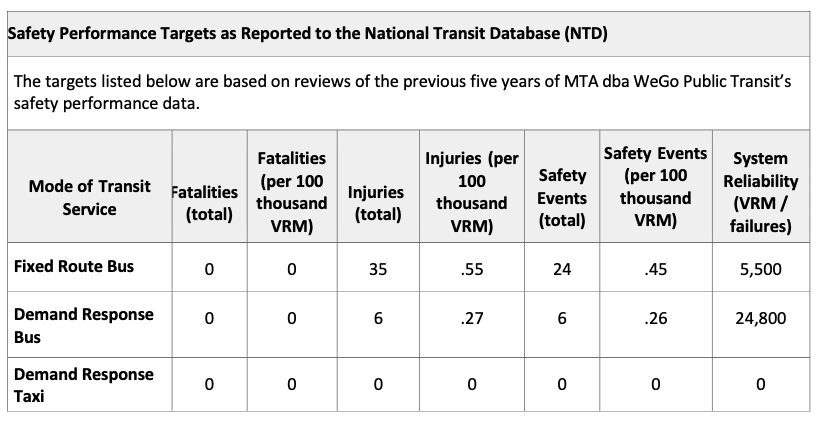

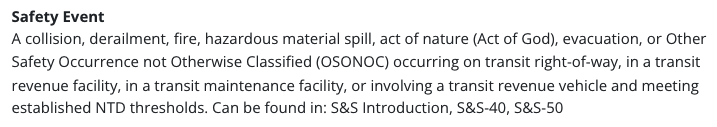

### 3.5.1 Understanding the 'Total Events' Column
<a id='3.5.1_Understanding_the_Total_Events_Column'></a>
The NTD database does not have a column called 'Total Safety Events' so I will verify that the 'Toal Events' column is a total of all the events listed in the definition above from given in the [FTA Glossary](https://www.transit.dot.gov/ntd/national-transit-database-ntd-glossary).

In [6]:
National_events = National_data.iloc[:, 18:24]
Nashville_events = Nashville_data.iloc[:, 18:24]
#National_events.reset_index(inplace=True)
#National_events = National_events.drop(columns='Date')
#Nashville_events = Nashville_events.drop(columns='Date')

In [7]:
#Check to see if 'Total Events" captures all data in columns 'Total Collisions', 'Total Derailments', 'Total Fires',
#'Total Security Events', and 'Total Events Not Otherwise Classified'

count1 = 0
count2 = 0

for i in National_events.index:
    if sum(National_events.iloc[i,[5]]) != sum(National_events.iloc[i,0:5]):
        count1 += 1
        list5.append(i)

for i in Nashville_events.index:
    if sum(Nashville_events.iloc[i,[5]]) != sum(Nashville_events.iloc[i,0:5]):
        count2 += 1
        list5.append(i)        

print('There are ',count1, "rows where 'Total Events' does not match the sum of the other National columns")
print('There are ',count2, "rows where 'Total Events' does not match the sum of the other Nashville columns")

There are  0 rows where 'Total Events' does not match the sum of the other National columns
There are  0 rows where 'Total Events' does not match the sum of the other Nashville columns


### 3.5.2 Dropping the Columns Captured by 'Total Events'
<a id='3.5.2_Dropping_the_Columns_Captured_by_Total_Events'></a>

In [8]:
National_data.shape

(129752, 26)

In [9]:
Nashville_data.shape

(750, 26)

In [10]:
National_data = National_data.drop(National_data.iloc[:, 18:23], axis=1)
Nashville_data = Nashville_data.drop(Nashville_data.iloc[:, 18:23], axis=1)


In [11]:
National_data.shape

(129752, 21)

In [12]:
Nashville_data.shape

(750, 21)

## 3.6 Creating a 'Date' Column
<a id='3.6_Creating_a_Date_Column'></a>

I will create a datetime column for time series analysis.

In [13]:
# Create date column, assign 1 as the day value

National_data['Date'] = pd.to_datetime(National_data[['Year','Month']].assign(Day=1))
Nashville_data['Date'] = pd.to_datetime(Nashville_data[['Year','Month']].assign(Day=1))

In [14]:
# make the date column the index

National_data = National_data.set_index('Date')
Nashville_data = Nashville_data.set_index('Date')

In [15]:
National_data.head()

5 DIgit NTD ID                                             Agency  \
Date                                                                            
2014-01-01               8  Tri-County Metropolitan Transportation Distric...   
2014-01-01               8  Tri-County Metropolitan Transportation Distric...   
2014-01-01           20008                          MTA New York City Transit   
2014-01-01           20008                          MTA New York City Transit   
2014-01-01           20008                          MTA New York City Transit   

                                            Organization Type Mode  \
Date                                                                 
2014-01-01  Independent Public Agency or Authority of Tran...   LR   
2014-01-01  Independent Public Agency or Authority of Tran...   MB   
2014-01-01  Subsidiary Unit of a Transit Agency, Reporting...   DR   
2014-01-01  Subsidiary Unit of a Transit Agency, Reporting...   HR   
2014-01-01  Subsidiary Unit of a Transit Agency, Reporting...   MB   

           Type of Service  Rail (Y/N)  Primary UZA Code  \
Date                                                       
2014-01-01              DO        True              24.0   
2014-01-01              DO       False              24.0   
2014-01-01              PT       False               1.0   
2014-01-01              DO        True               1.0   
2014-01-01              DO       False               1.0   

                     Primary UZA Name  Primary UZA Sq Miles  \
Date                                                          
2014-01-01            Portland, OR-WA                 524.0   
2014-01-01            Portland, OR-WA                 524.0   
2014-01-01  New York-Newark, NY-NJ-CT                3450.0   
2014-01-01  New York-Newark, NY-NJ-CT                3450.0   
2014-01-01  New York-Newark, NY-NJ-CT                3450.0   

            Primary UZA Population  ...  Service Area Population  Year  Month  \
Date                                ...                                         
2014-01-01               1849898.0  ...                1542044.0  2014      1   
2014-01-01               1849898.0  ...                1542044.0  2014      1   
2014-01-01              18351295.0  ...                8491079.0  2014      1   
2014-01-01              18351295.0  ...                8491079.0  2014      1   
2014-01-01              18351295.0  ...                8491079.0  2014      1   

            Vehicles  Vehicle Revenue Miles  Vehicle Revenue Hours  Ridership  \
Date                                                                            
2014-01-01       104                 636145                  43533    3030400   
2014-01-01       516                1605059                 136485    5235300   
2014-01-01      1579                3704416                 317934     474836   
2014-01-01      5232               29283817                1611532  208881579   
2014-01-01      3282                7166888                1013133   57418953   

            Total Events  Total Fatalities  Total Injuries  
Date                                                        
2014-01-01             1                 0               1  
2014-01-01             6                 0              11  
2014-01-01            11                 0              17  
2014-01-01            13                 2               9  
2014-01-01            30                 1              42  

[5 rows x 21 columns]

In [16]:
National_data.shape

(129752, 21)

## 3.7 Exploratory Aggregation
<a id='3.7_Exploratory_Aggregation'></a>

### 3.7.1 Time Series of the Features of the Future Target
<a id='3.7.1_Time_Series_of_the_Features_of_the_Future_Target'></a>
Looking specifically at features which will be used to calculate the target later in the notebook.

|  |  |
|:---------|:-------------|
|Time|Time|
|Dimensions (National)||
|Dimensions (Nashville)|Location|
|Features of the Target|Total Fatalities|
||Total Injuries|
||Total Events|
||Vehicle Revenue Miles|


In [17]:
# Aggregation at the National level
# for time series of Total Fatalities, Injuries, Events, and Vehicle Revenue Miles
# which are the columns I will use to define safety (the target) later in the notebook

# The National_data dataframe has one monthly entry 
# for each mode for each section (as defined in 3.2).
# The aggregation below (National_FIEVRM_df) disregards section and mode
# and yields one single row per month

National_FIEVRM_df = National_data.groupby('Date').agg(
    Fatalities_sum=('Total Fatalities', 'sum'),
    Injuries_sum=('Total Injuries', 'sum'),
    Events_sum=('Total Events', 'sum'),
    VRM_sum=('Vehicle Revenue Miles','sum')
)


In [18]:
# 102 rows - each representing of month of National data
# 4 columns - each containing the sum for the entire nation for that month

National_FIEVRM_df.shape

(102, 4)

In [19]:
National_FIEVRM_df.head()

Fatalities_sum  Injuries_sum  Events_sum    VRM_sum
Date                                                           
2014-01-01              20           797         531  328452031
2014-02-01              18           853         528  302314486
2014-03-01              23           903         536  332714067
2014-04-01              16           777         505  337326111
2014-05-01              18           998         558  335112466

In [20]:
National_FIEVRM_df.tail()

Fatalities_sum  Injuries_sum  Events_sum    VRM_sum
Date                                                           
2022-02-01              28           664         742  274711851
2022-03-01              25           720         767  312390870
2022-04-01              38           620         701  294246129
2022-05-01              28           622         694  299658724
2022-06-01              19           727         681  295103674

In [21]:
plt.style.use('fivethirtyeight')


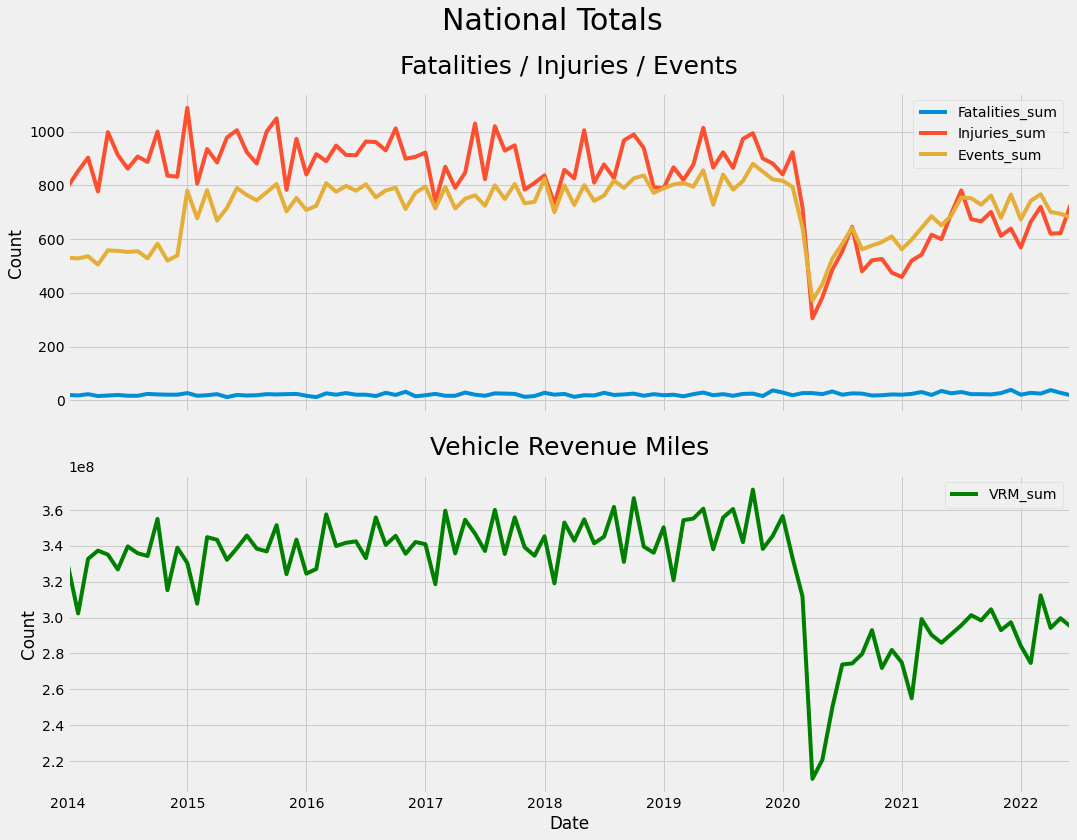

In [22]:
fig, ax =plt.subplots(2,1,figsize=(16,12), sharex=True)
fig.suptitle("National Totals", fontsize=30)
#plt.subplots_adjust(hspace=1)

National_FIEVRM_df[['Fatalities_sum','Injuries_sum','Events_sum']].plot(kind='line',legend=True, ax=ax[0])
ax[0].set_title("Fatalities / Injuries / Events", fontsize=25, pad=20)
ax[0].set_ylabel("Count")
#ax[0].yaxis.set_major_locator(ticker.MultipleLocator(50))


National_FIEVRM_df[['VRM_sum']].plot(kind='line',legend=True, ax=ax[1], color='green')
ax[1].set_title("Vehicle Revenue Miles", fontsize=25, pad=20)
ax[1].set_ylabel("Count")

plt.show()

In [23]:
# Aggregation at the local level
# for time series of Total Fatalities, Injuries, Events, and Vehicle Revenue Miles
# which are the columns I will use to define safety (the target) later in the notebook

# The Nashville_data dataframe has one monthly entry 
# for each mode for each section (as defined in 3.2).
# The aggregation below (Nashville_FIEVRM_df) looks at 
# one specific location (as defined in 3.2) - Nashville
# while disregarding mode
# yielding one single row per month for Nashville only

location = (National_data['5 DIgit NTD ID'].isin([40178, 40004, 40159])) & \
           (National_data['Primary UZA Name'].isin(['Nashville-Davidson, TN'])) & \
           (National_data['Agency'].isin(['The Transportation Management Association Group',
       'Metropolitan Transit Authority',
       'Regional Transportation Authority']))

subset = National_data[location]


In [24]:
Nashville_FIEVRM_df = subset.groupby('Date').agg(
    Fatalities_sum=('Total Fatalities', 'sum'),
    Injuries_sum=('Total Injuries', 'sum'),
    Events_sum=('Total Events', 'sum'),
    VRM_sum=('Vehicle Revenue Miles','sum')
)


In [25]:
Nashville_FIEVRM_df.shape

(102, 4)

In [26]:
Nashville_FIEVRM_df.head()

Fatalities_sum  Injuries_sum  Events_sum  VRM_sum
Date                                                         
2014-01-01               0             0           0   887200
2014-02-01               0             0           1   831134
2014-03-01               0             2           2   890363
2014-04-01               0             2           2   920397
2014-05-01               0             5           3   907490

In [27]:
Nashville_FIEVRM_df.tail()

Fatalities_sum  Injuries_sum  Events_sum  VRM_sum
Date                                                         
2022-02-01               0             2           3   750457
2022-03-01               0             0           0   870772
2022-04-01               1             2           3   863615
2022-05-01               0             5           2   877411
2022-06-01               0             1           1   889281

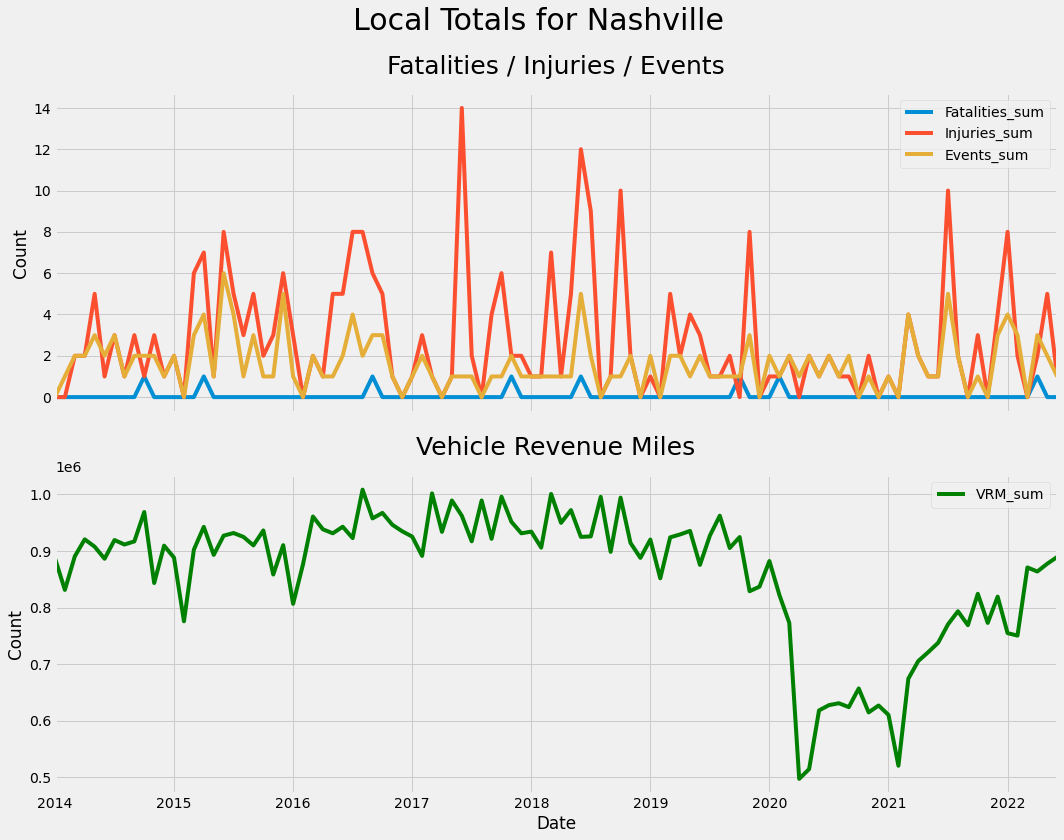

In [28]:
fig, ax =plt.subplots(2,1,figsize=(16,12), sharex=True)
fig.suptitle("Local Totals for Nashville", fontsize=30)
#plt.subplots_adjust(hspace=1)

Nashville_FIEVRM_df[['Fatalities_sum','Injuries_sum','Events_sum']].plot(kind='line',legend=True, ax=ax[0])
ax[0].set_title("Fatalities / Injuries / Events", fontsize=25, pad=20)
ax[0].set_ylabel("Count")

Nashville_FIEVRM_df[['VRM_sum']].plot(kind='line',legend=True, ax=ax[1], color='green')
ax[1].set_title("Vehicle Revenue Miles", fontsize=25, pad=20)
ax[1].set_ylabel("Count")

plt.show()

### 3.7.2 Time Series of the Feature of the Future Target by Mode
<a id='3.7.2_Time_Series_of_the_Future_Target_by_Mode'></a>
Looking at the same features again but this time with respect to mode.  

|  |  |
|:---------|:-------------|
|Time|Time|
|Dimensions (National)|Mode|
|Dimensions (Nashville)|Location, Mode|
|Features of the Target|Total Fatalities|
||Total Injuries|
||Total Events|
||Vehicle Revenue Miles|


In [29]:

National_mode_df = National_data.groupby(['Date','Mode']).agg(
    Fatalities_sum=('Total Fatalities', 'sum'),
    Injuries_sum=('Total Injuries', 'sum'),
    Events_sum=('Total Events', 'sum'),
    VRM_sum=('Vehicle Revenue Miles','sum')
)

In [30]:

Nashville_mode_df = subset.groupby(['Date','Mode']).agg(
    Fatalities_sum=('Total Fatalities', 'sum'),
    Injuries_sum=('Total Injuries', 'sum'),
    Events_sum=('Total Events', 'sum'),
    VRM_sum=('Vehicle Revenue Miles','sum')
)


In [31]:
National_mode_df.head()

Fatalities_sum  Injuries_sum  Events_sum   VRM_sum
Date       Mode                                                    
2014-01-01 CB                 2            40           6   9799029
           CC                 0             0           0     25284
           CR                 0             0           0  28062564
           DR                 0            76          52  59090140
           HR                 5            31          45  55530393

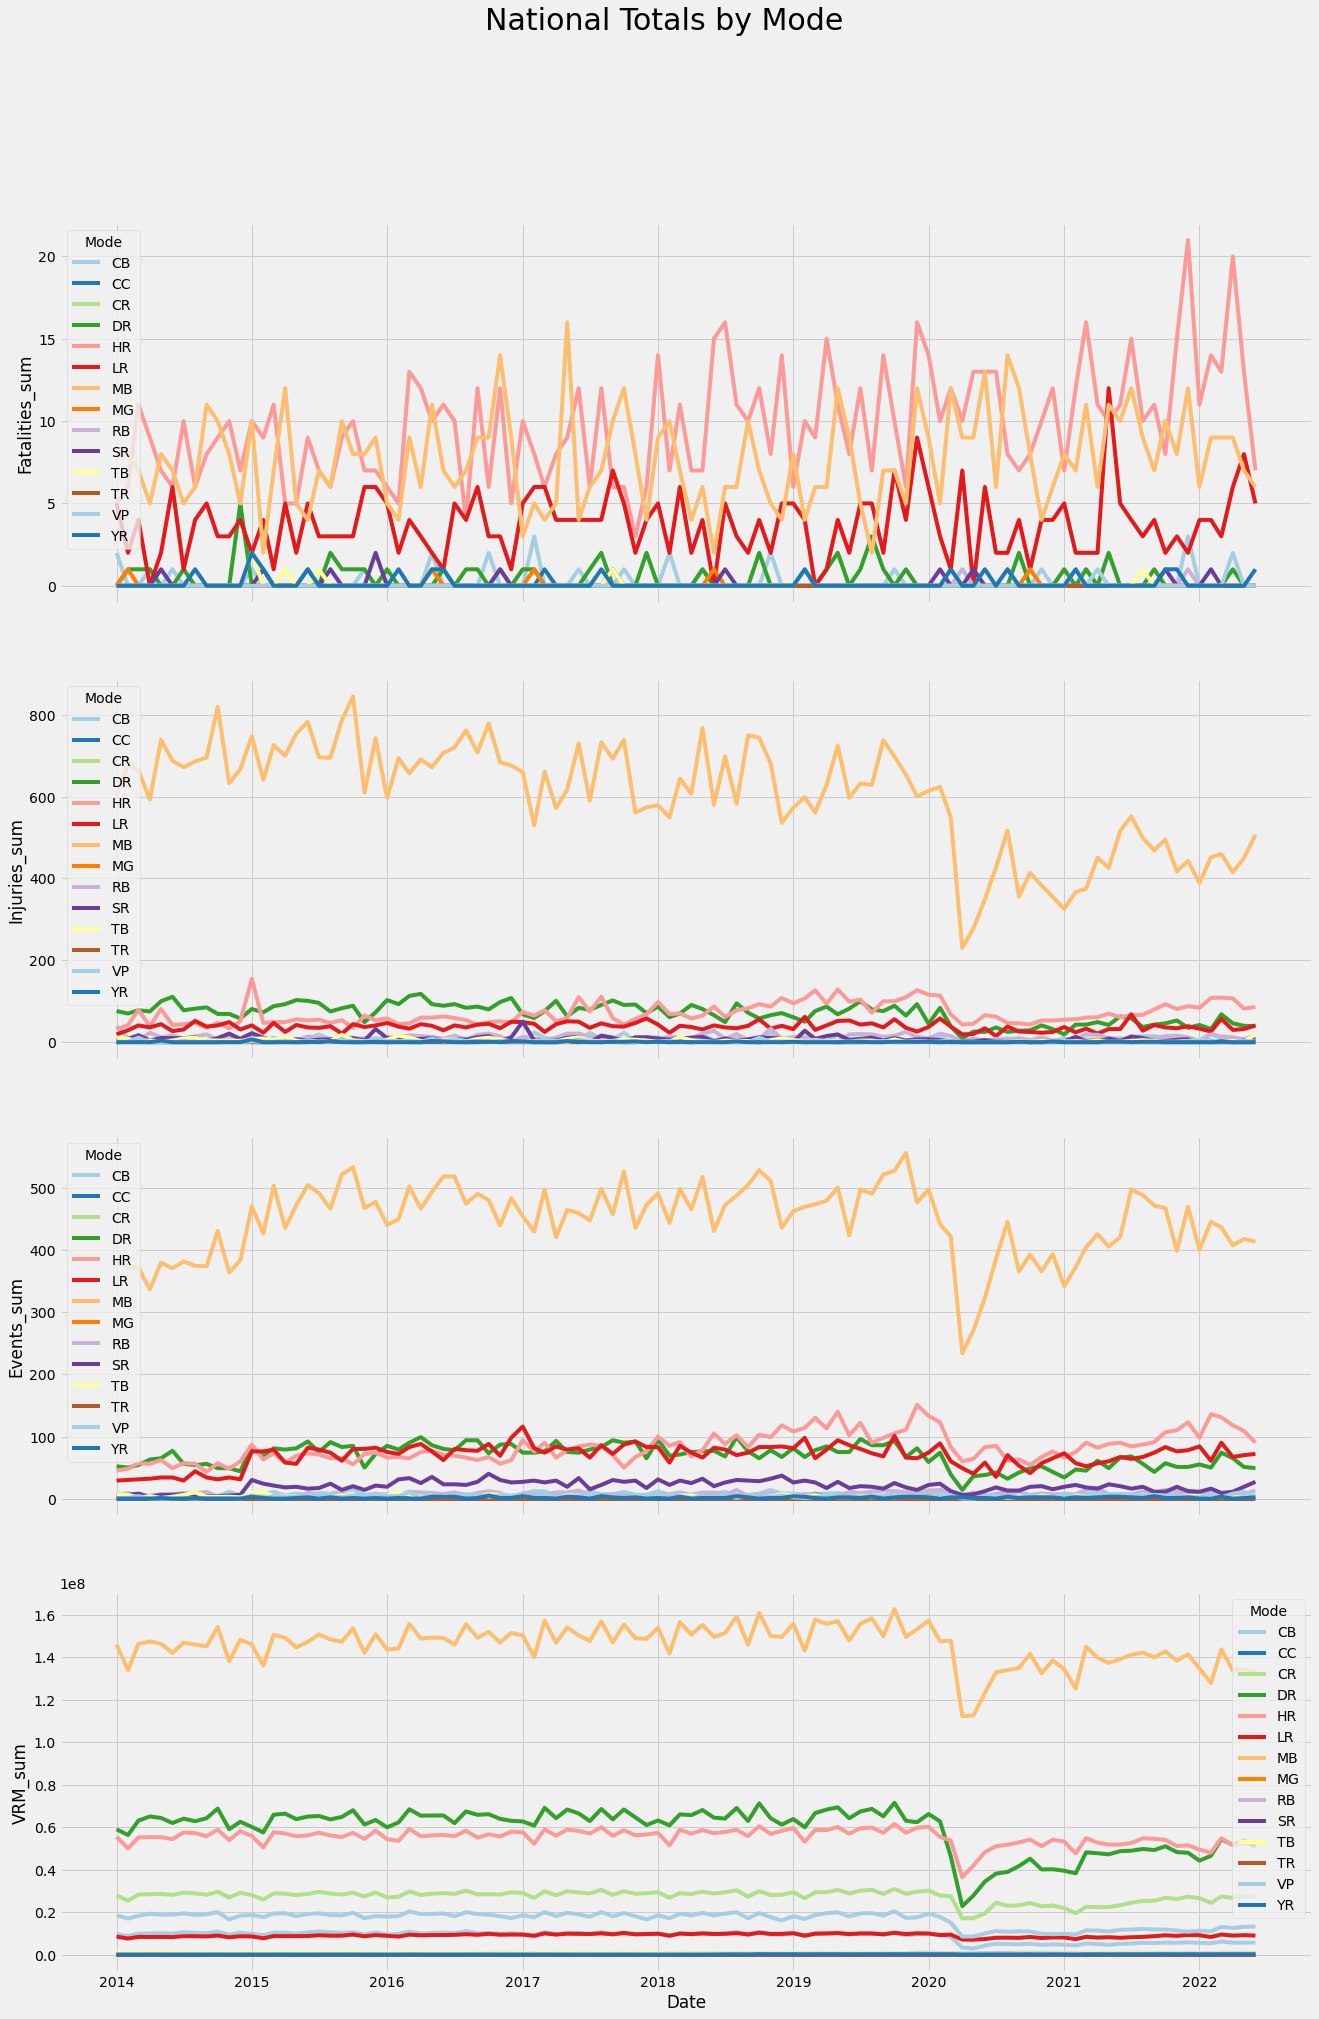

In [32]:
# Looking at the columns which will define safety with respect to each mode
# on the National level

fig, ax =plt.subplots(4,1,figsize=(20,30), sharex=True)
fig.suptitle("National Totals by Mode", fontsize=30)

sns.lineplot(data = National_mode_df, x = 'Date', y = 'Fatalities_sum', hue = 'Mode', ax=ax[0], palette='Paired')

sns.lineplot(data = National_mode_df, x = 'Date', y = 'Injuries_sum', hue = 'Mode', ax=ax[1], palette='Paired')

sns.lineplot(data = National_mode_df, x = 'Date', y = 'Events_sum', hue = 'Mode', ax=ax[2], palette='Paired')

sns.lineplot(data = National_mode_df, x = 'Date', y = 'VRM_sum', hue = 'Mode', ax=ax[3], palette='Paired')


plt.show()

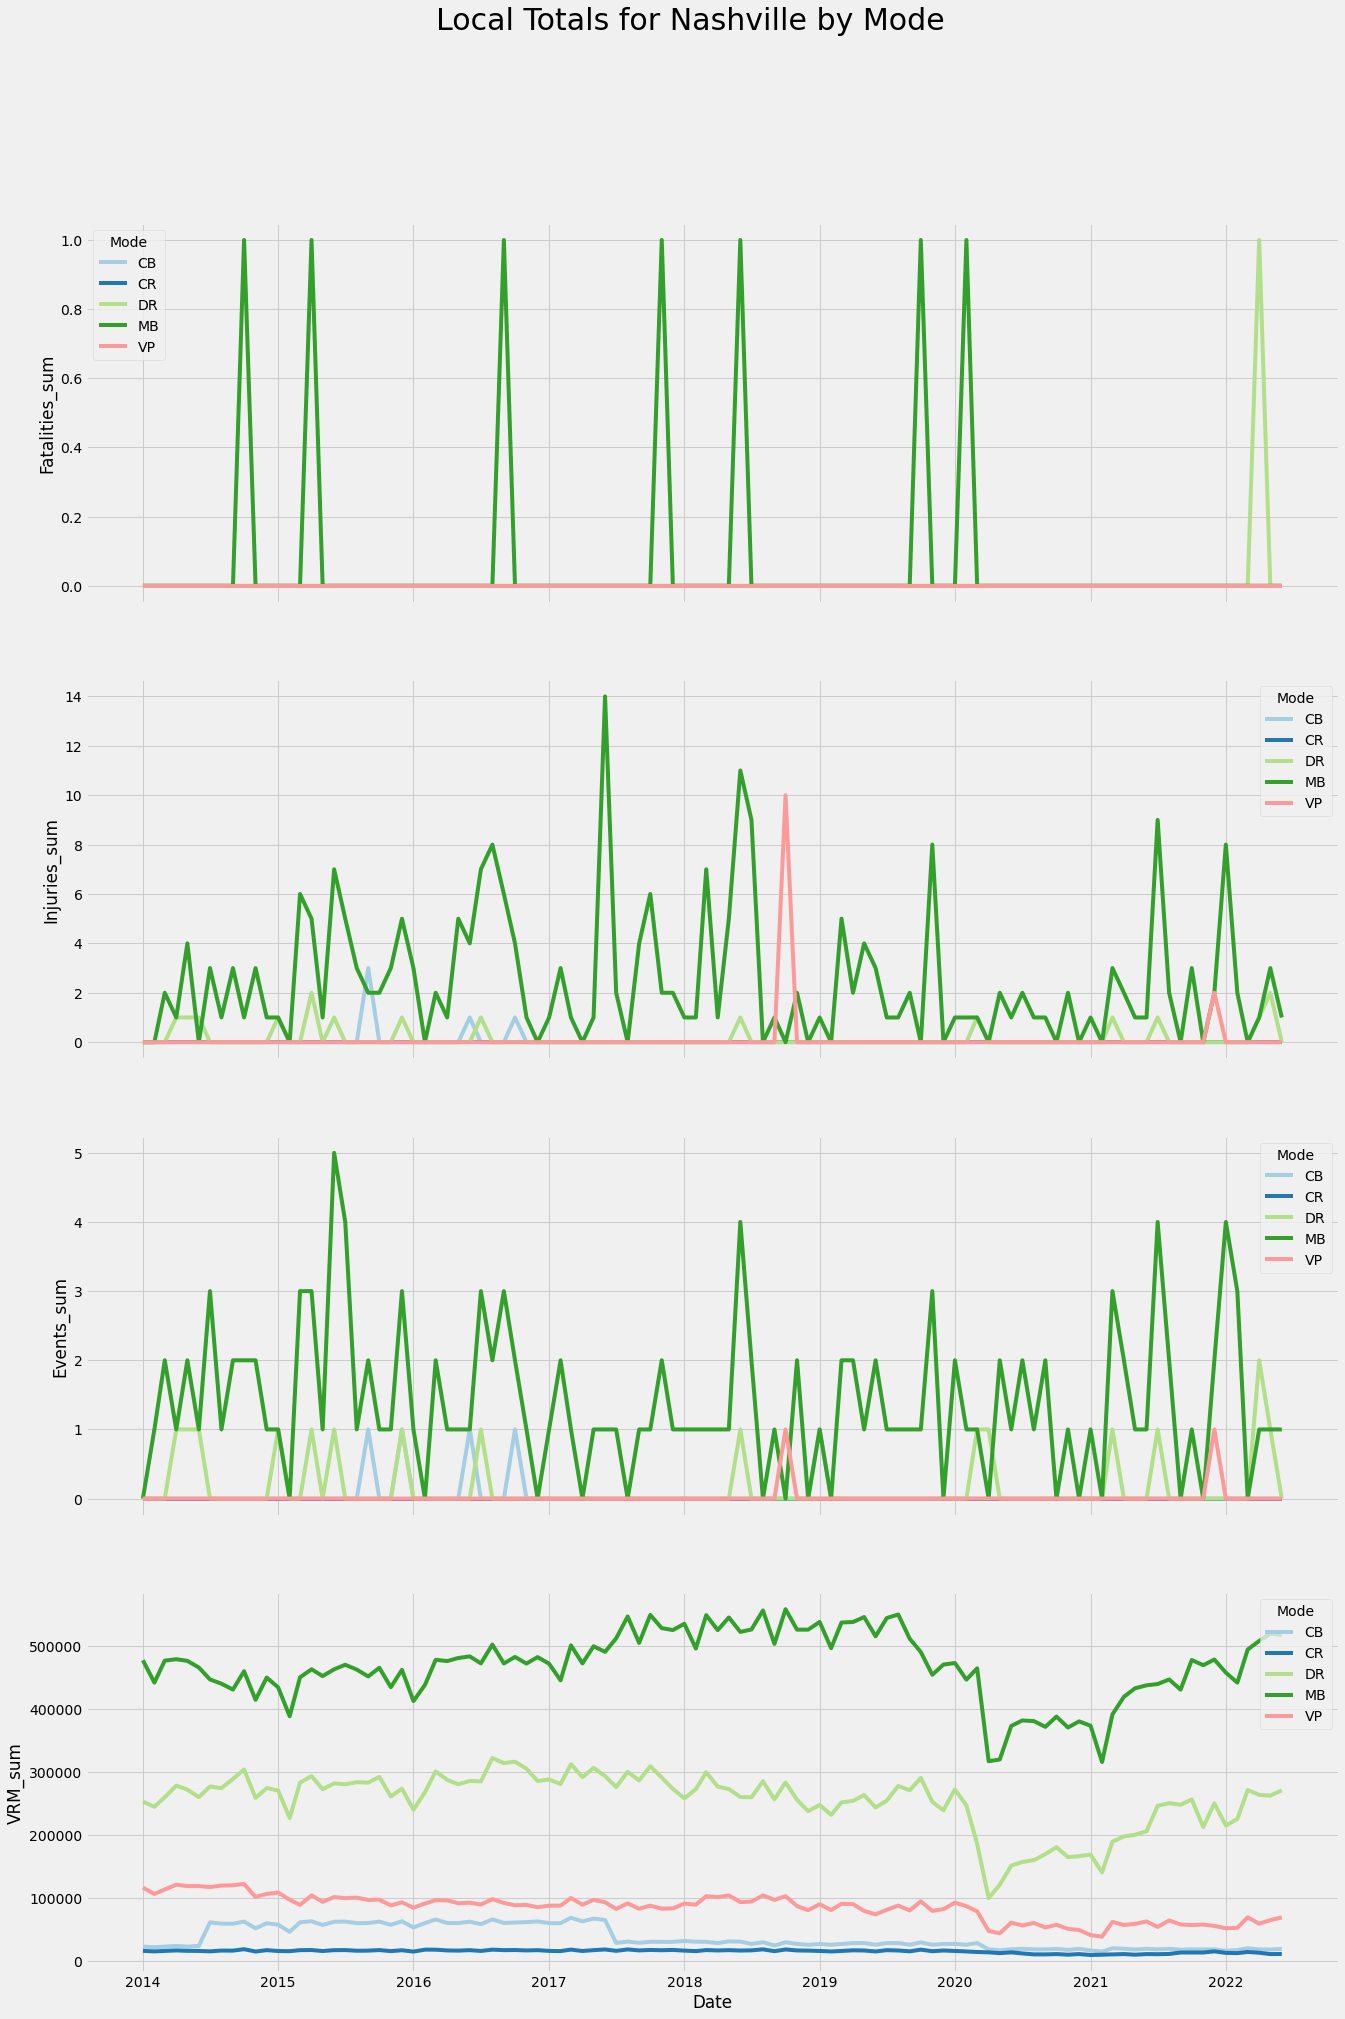

In [33]:
# Looking at the columns which will define safety with respect to each mode
# on the local level (Nashville)


fig, ax =plt.subplots(4,1,figsize=(20,30), sharex=True)
fig.suptitle("Local Totals for Nashville by Mode", fontsize=30)

sns.lineplot(data = Nashville_mode_df, x = 'Date', y = 'Fatalities_sum', hue = 'Mode', ax=ax[0], palette='Paired')

sns.lineplot(data = Nashville_mode_df, x = 'Date', y = 'Injuries_sum', hue = 'Mode', ax=ax[1], palette='Paired')

sns.lineplot(data = Nashville_mode_df, x = 'Date', y = 'Events_sum', hue = 'Mode', ax=ax[2], palette='Paired')

sns.lineplot(data = Nashville_mode_df, x = 'Date', y = 'VRM_sum', hue = 'Mode', ax=ax[3], palette='Paired')


plt.show()

In [34]:
#National_data.info()

### 3.7.3 Time Series Examining Light Rail
<a id='3.7.3_Time_Series_Examining_Light_Rail'></a>
Here, I'll take a look at the statistics for a subset of locations which have modes that are exactly the same as Nashville's.  Then I'll take a look at locations which have modes up to an including the ones that Nashville has and I'll compare them to locations which have those modes plus light rail.

Since I am looking for areas approximating the city level with no further subsetting for service areas, I will use locations instead of sections (both defined in 3.2).


In [35]:
# Creating a column which contains all modes for that 'Primary UZA Name' in alphabetical order

National_data_copy = National_data.copy()
National_data_copy = National_data_copy.sort_values(by='Mode')
National_data_copy

df = National_data_copy.groupby('Primary UZA Name').agg(
    all_Modes = ('Mode', 'unique')
)

National_data = National_data.join(df, on='Primary UZA Name')

In [36]:
National_data['all_Modes'] = National_data['all_Modes'].astype('string')
National_data['all_Modes'].dtype

string[python]

**Part 1: Locations with _the same_ modes as Nashville**

In [37]:
def extract_values_from_column(the_df, the_col, the_values):
    return the_df.loc[the_df[the_col] == (the_values)]

In [38]:
modes_same_as_Nashville_df = extract_values_from_column(National_data, 'all_Modes',("['CB' 'CR' 'DR' 'MB' 'VP']"))
#modes_same_as_Nashville_df.head()


In [39]:
modes_same_as_Nashville_df.shape

(1384, 22)

In [40]:
modes_same_as_Nashville_df['Primary UZA Name'].unique()

array(['Stockton, CA', 'Nashville-Davidson, TN'], dtype=object)

Since there is only one other location that has exactly the same modes as Nashville, the data will not be very informative for the purposes of the project, but I will take a look at the two anyway.

In [41]:
modes_subset_same_as_Nashville = modes_same_as_Nashville_df.groupby(['Date', 'Primary UZA Name']).agg(
    Fatalities_sum=('Total Fatalities', 'sum'),
    Injuries_sum=('Total Injuries', 'sum'),
    Events_sum=('Total Events', 'sum'),
    VRM_sum=('Vehicle Revenue Miles','sum'),
    P_UZA_SM_sum = ('Primary UZA Sq Miles', 'sum'),
    P_UZA_P_sum = ('Primary UZA Population', 'sum'),
    SA_SM_sum = ('Service Area Sq Miles', 'sum'),
    SA_P_sum = ('Service Area Population', 'sum'),
    Ridership_sum = ('Ridership','sum')
)

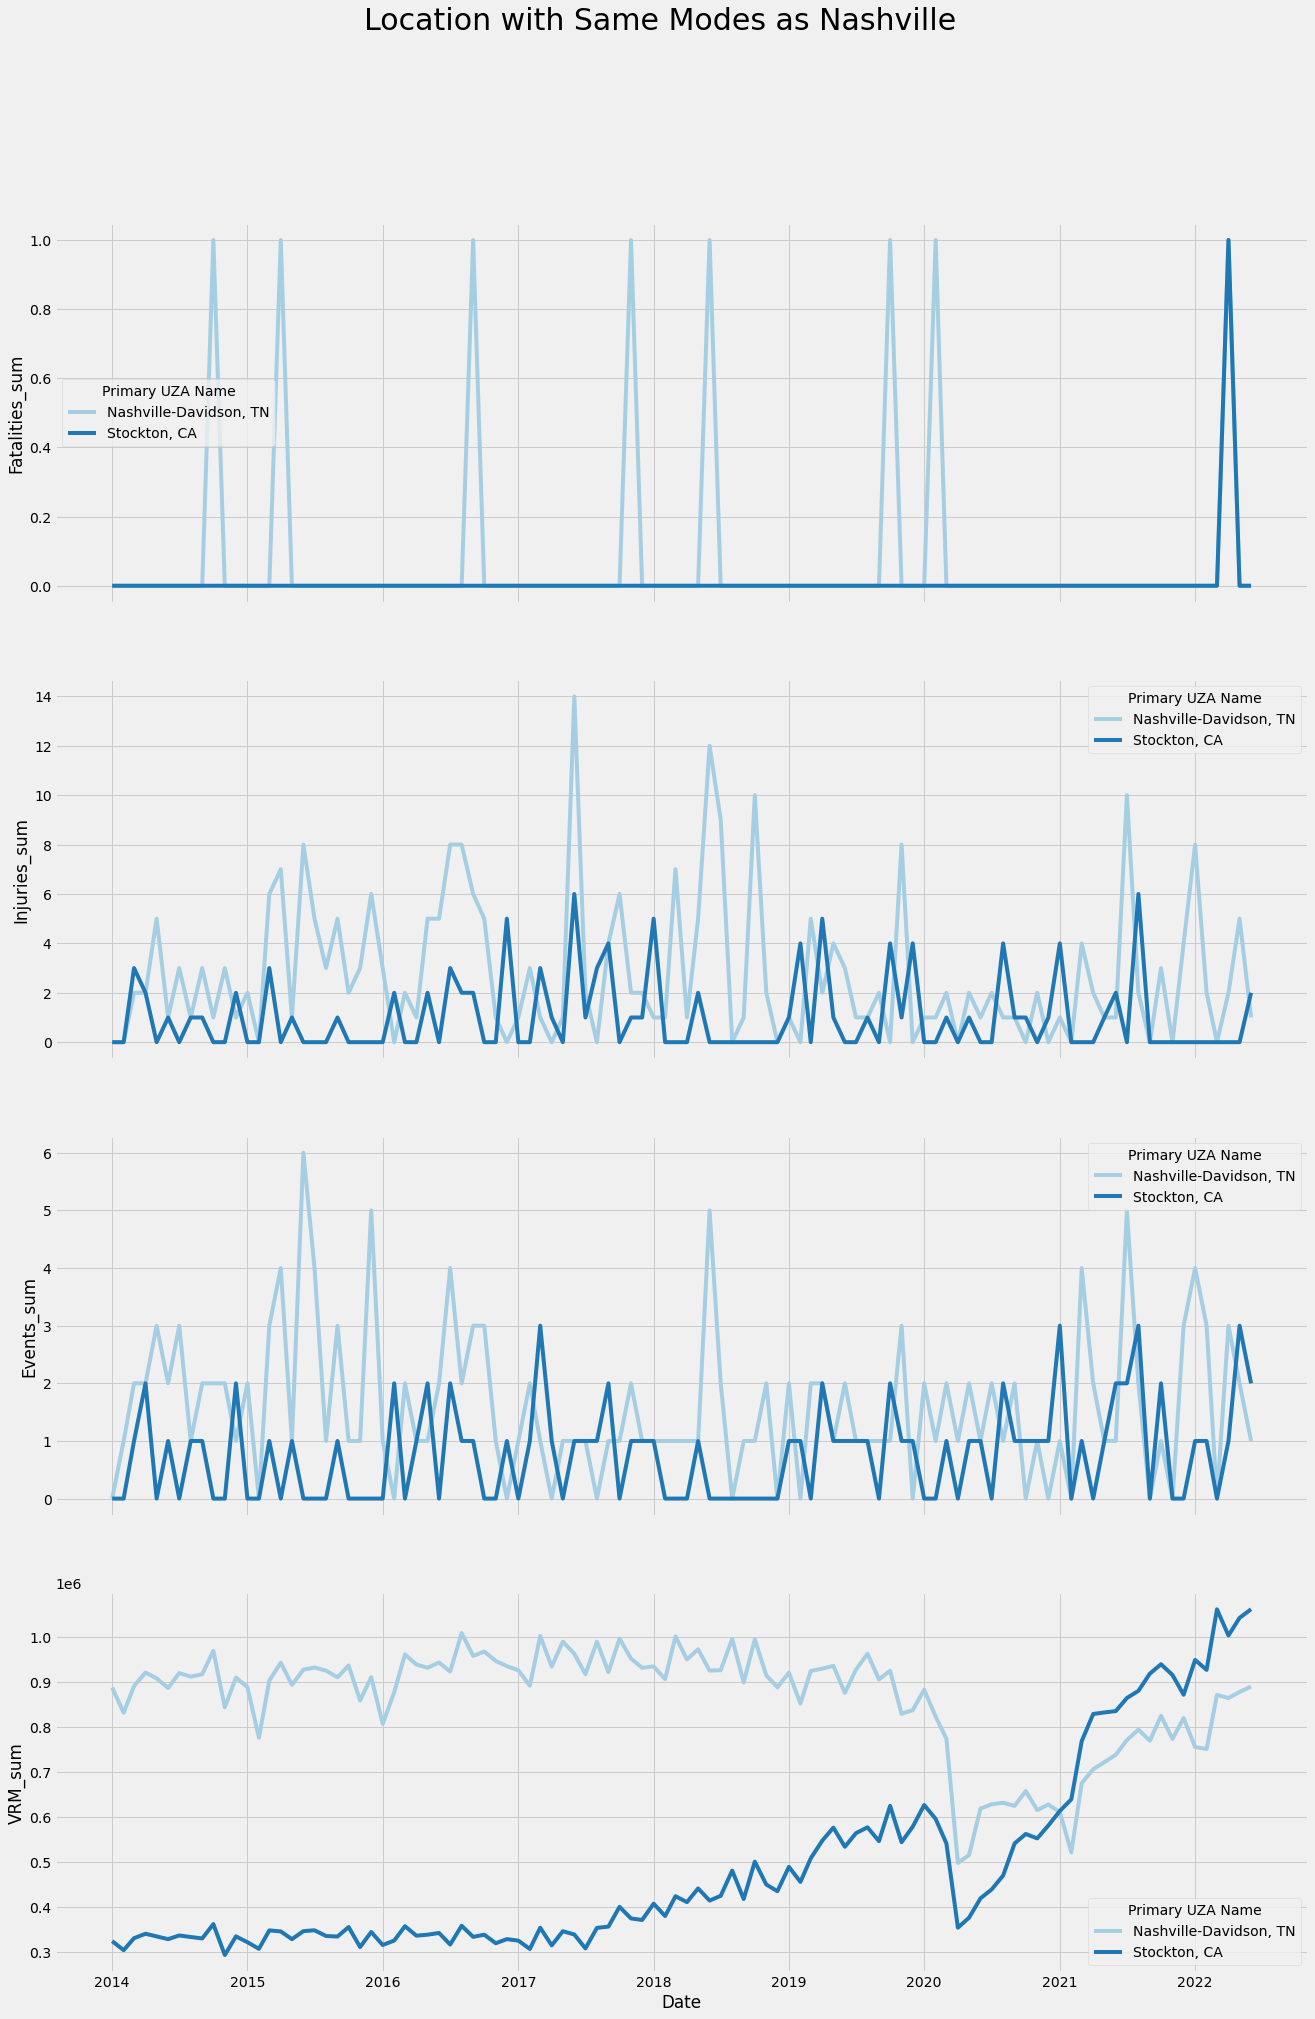

In [42]:
fig, ax =plt.subplots(4,1,figsize=(20,30), sharex=True)
fig.suptitle("Location with Same Modes as Nashville", fontsize=30)

sns.lineplot(data = modes_subset_same_as_Nashville, x = 'Date', y = 'Fatalities_sum', hue = 'Primary UZA Name', ax=ax[0], palette='Paired')

sns.lineplot(data = modes_subset_same_as_Nashville, x = 'Date', y = 'Injuries_sum', hue = 'Primary UZA Name', ax=ax[1], palette='Paired')

sns.lineplot(data = modes_subset_same_as_Nashville, x = 'Date', y = 'Events_sum', hue = 'Primary UZA Name', ax=ax[2], palette='Paired')


sns.lineplot(data = modes_subset_same_as_Nashville, x = 'Date', y = 'VRM_sum', hue = 'Primary UZA Name', ax=ax[3], palette='Paired')

plt.show()

**Part 2: Locations with modes up to and including Nashville's and, both separately and collectively, locations with modes up to and including Nashville's but which also have light rail.**

In [43]:
def extract_more_values_from_column(the_df, the_col, the_values):
    return the_df.loc[the_df[the_col].isin(the_values)]

In [44]:
# if "secret" in raw_file_content:
# if "secret" not in raw_file_content:

In [45]:
modes_similar_to_Nashville = extract_more_values_from_column(National_data, 'all_Modes', 
                                ("['DR' 'MB']", 
                                 "['CB' 'DR' 'MB' 'VP']", 
                                 "['DR' 'MB' 'VP']", 
                                 "['CB' 'MB']", 
                                 "['CB' 'DR' 'MB']", 
                                 "['MB']", "['DR']", 
                                 "['CB' 'DR']", 
                                 "['CR' 'MB']", 
                                 "['CB' 'CR' 'DR' 'MB' 'RB']", 
                                 "['CR' 'DR' 'MB']", 
                                 "['CB']", 
                                 "['DR' 'VP']", 
                                 "['VP']"))


In [46]:
modes_similar_to_Nashville['Primary UZA Name'].nunique()

261

In [47]:
modes_similar_to_Nashville_plus_LR = extract_more_values_from_column(National_data, 'all_Modes', 
                                ("['DR' 'MB']", 
                                 "['CB' 'DR' 'MB' 'VP']", 
                                 "['DR' 'MB' 'VP']", 
                                 "['CB' 'MB']", 
                                 "['CB' 'DR' 'MB']", 
                                 "['MB']", "['DR']", 
                                 "['CB' 'DR']", 
                                 "['CR' 'MB']", 
                                 "['CB' 'CR' 'DR' 'MB' 'RB']", 
                                 "['CR' 'DR' 'MB']", 
                                 "['CB']", 
                                 "['DR' 'VP']", 
                                 "['VP']", 
                                 "['DR' 'LR' 'MB' 'VP']", 
                                 "['CB' 'CR' 'DR' 'LR' 'MB' 'VP']", 
                                 "['CB' 'DR' 'LR' 'MB' 'VP']", 
                                 "['CR' 'DR' 'LR' 'MB' 'VP']", 
                                 "['DR' 'LR' 'MB']", ))


In [48]:
modes_similar_to_Nashville_plus_LR['Primary UZA Name'].nunique()

270

In [49]:
modes_LR = extract_more_values_from_column(National_data, 'all_Modes', 
                                ("['DR' 'LR' 'MB' 'VP']", 
                                 "['CB' 'CR' 'DR' 'LR' 'MB' 'VP']", 
                                 "['CB' 'DR' 'LR' 'MB' 'VP']", 
                                 "['CR' 'DR' 'LR' 'MB' 'VP']", 
                                 "['DR' 'LR' 'MB']", ))


In [50]:
modes_LR['Primary UZA Name'].nunique()

9

In [51]:
# perform aggregation on subset

In [52]:
#modes_similar_to_Nashville.head()

In [53]:
#National_data.columns

In [54]:
modes_subset = modes_similar_to_Nashville.groupby('Date').agg(
    Fatalities_avg=('Total Fatalities', 'mean'),
    Injuries_avg=('Total Injuries', 'mean'),
    Events_avg=('Total Events', 'mean'),
    VRM_avg=('Vehicle Revenue Miles','mean'),
    P_UZA_SM_avg = ('Primary UZA Sq Miles', 'mean'),
    P_UZA_P_avg = ('Primary UZA Population', 'mean'),
    SA_SM_avg = ('Service Area Sq Miles', 'mean'),
    SA_P_avg = ('Service Area Population', 'mean'),
    Ridership_avg = ('Ridership','mean')
)

In [55]:
modes_subset_plus_LR = modes_similar_to_Nashville_plus_LR.groupby('Date').agg(
    Fatalities_avg=('Total Fatalities', 'mean'),
    Injuries_avg=('Total Injuries', 'mean'),
    Events_avg=('Total Events', 'mean'),
    VRM_avg=('Vehicle Revenue Miles','mean'),
    P_UZA_SM_avg = ('Primary UZA Sq Miles', 'mean'),
    P_UZA_P_avg = ('Primary UZA Population', 'mean'),
    SA_SM_avg = ('Service Area Sq Miles', 'mean'),
    SA_P_avg = ('Service Area Population', 'mean'),
    Ridership_avg = ('Ridership','mean')
)

In [56]:
modes_subset_LR = modes_LR.groupby('Date').agg(
    Fatalities_avg=('Total Fatalities', 'mean'),
    Injuries_avg=('Total Injuries', 'mean'),
    Events_avg=('Total Events', 'mean'),
    VRM_avg=('Vehicle Revenue Miles','mean'),
    P_UZA_SM_avg = ('Primary UZA Sq Miles', 'mean'),
    P_UZA_P_avg = ('Primary UZA Population', 'mean'),
    SA_SM_avg = ('Service Area Sq Miles', 'mean'),
    SA_P_avg = ('Service Area Population', 'mean'),
    Ridership_avg = ('Ridership','mean')
)

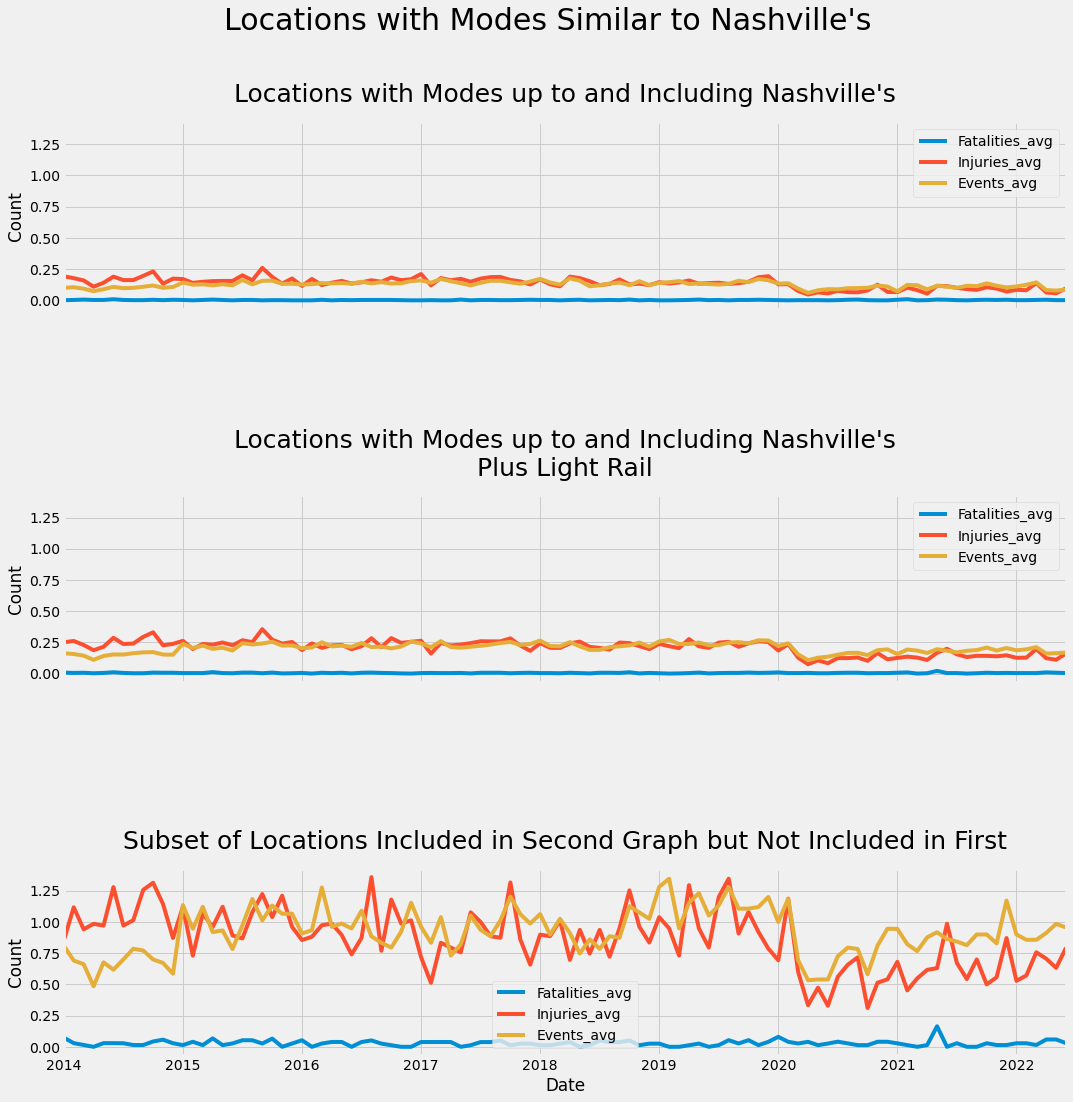

In [57]:
fig, ax =plt.subplots(3,1,figsize=(16,16), sharex=True, sharey=True)
fig.suptitle("Locations with Modes Similar to Nashville's", fontsize=30)
plt.subplots_adjust(hspace=1)

modes_subset[['Fatalities_avg','Injuries_avg','Events_avg']].plot(kind='line',legend=True, ax=ax[0])
ax[0].set_title("Locations with Modes up to and Including Nashville's", fontsize=25, pad=20)
ax[0].set_ylabel("Count")

modes_subset_plus_LR[['Fatalities_avg','Injuries_avg','Events_avg']].plot(kind='line',legend=True, ax=ax[1])
ax[1].set_title("Locations with Modes up to and Including Nashville's\nPlus Light Rail", fontsize=25, pad=20)
ax[1].set_ylabel("Count")


modes_subset_LR[['Fatalities_avg','Injuries_avg','Events_avg']].plot(kind='line',legend=True, ax=ax[2])
ax[2].set_title("Subset of Locations Included in Second Graph but Not Included in First", fontsize=25, pad=20)
ax[2].set_ylabel("Count")


plt.show()

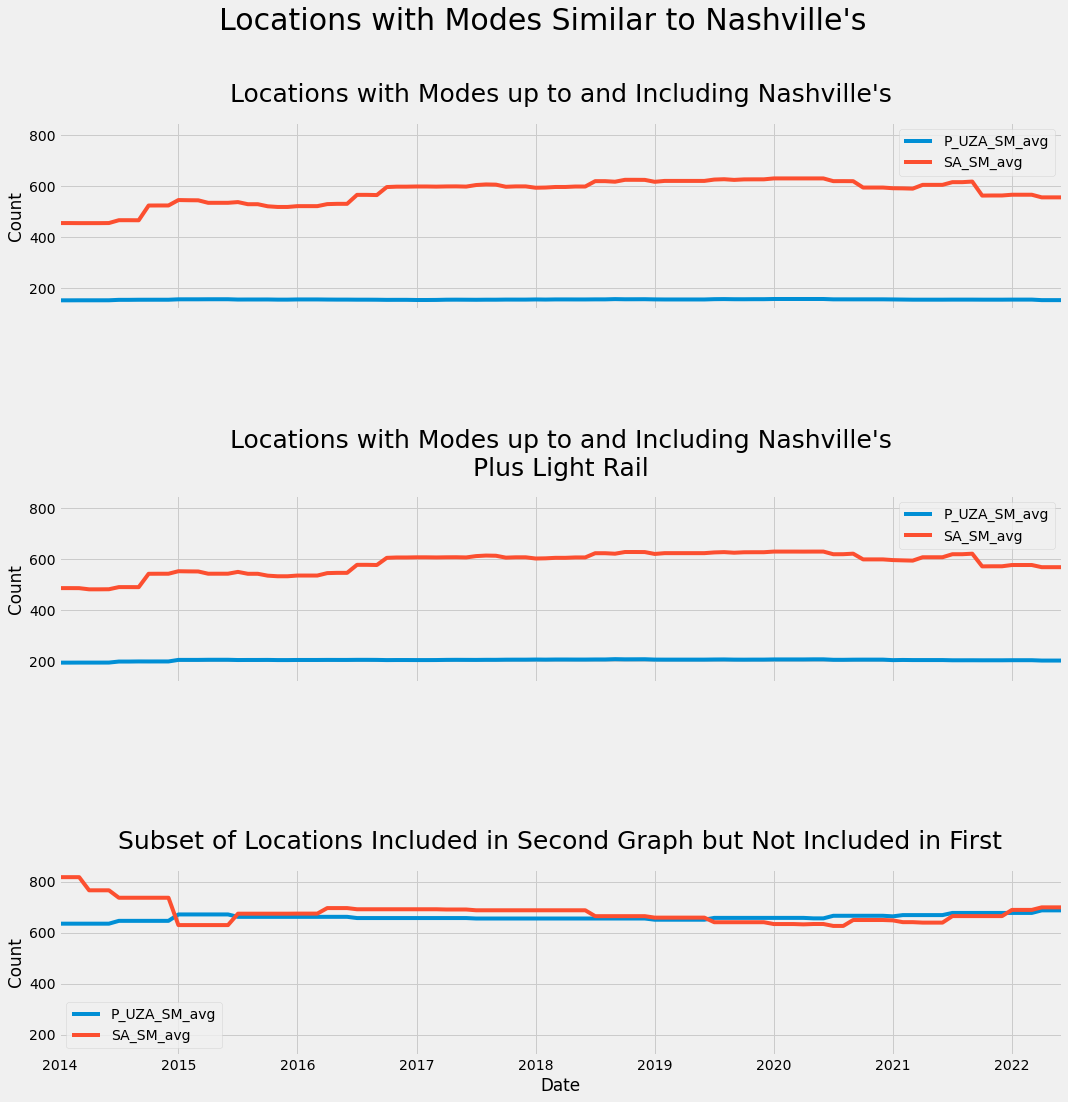

In [58]:
fig, ax =plt.subplots(3,1,figsize=(16,16), sharex=True, sharey=True)
fig.suptitle("Locations with Modes Similar to Nashville's", fontsize=30)
plt.subplots_adjust(hspace=1)

modes_subset[['P_UZA_SM_avg',
            'SA_SM_avg']].plot(kind='line',legend=True, ax=ax[0])
ax[0].set_title("Locations with Modes up to and Including Nashville's", fontsize=25, pad=20)
ax[0].set_ylabel("Count")

modes_subset_plus_LR[['P_UZA_SM_avg',
            'SA_SM_avg']].plot(kind='line',legend=True, ax=ax[1])
ax[1].set_title("Locations with Modes up to and Including Nashville's\nPlus Light Rail", fontsize=25, pad=20)
ax[1].set_ylabel("Count")


modes_subset_LR[['P_UZA_SM_avg',
            'SA_SM_avg']].plot(kind='line',legend=True, ax=ax[2])
ax[2].set_title("Subset of Locations Included in Second Graph but Not Included in First", fontsize=25, pad=20)
ax[2].set_ylabel("Count")


plt.show()

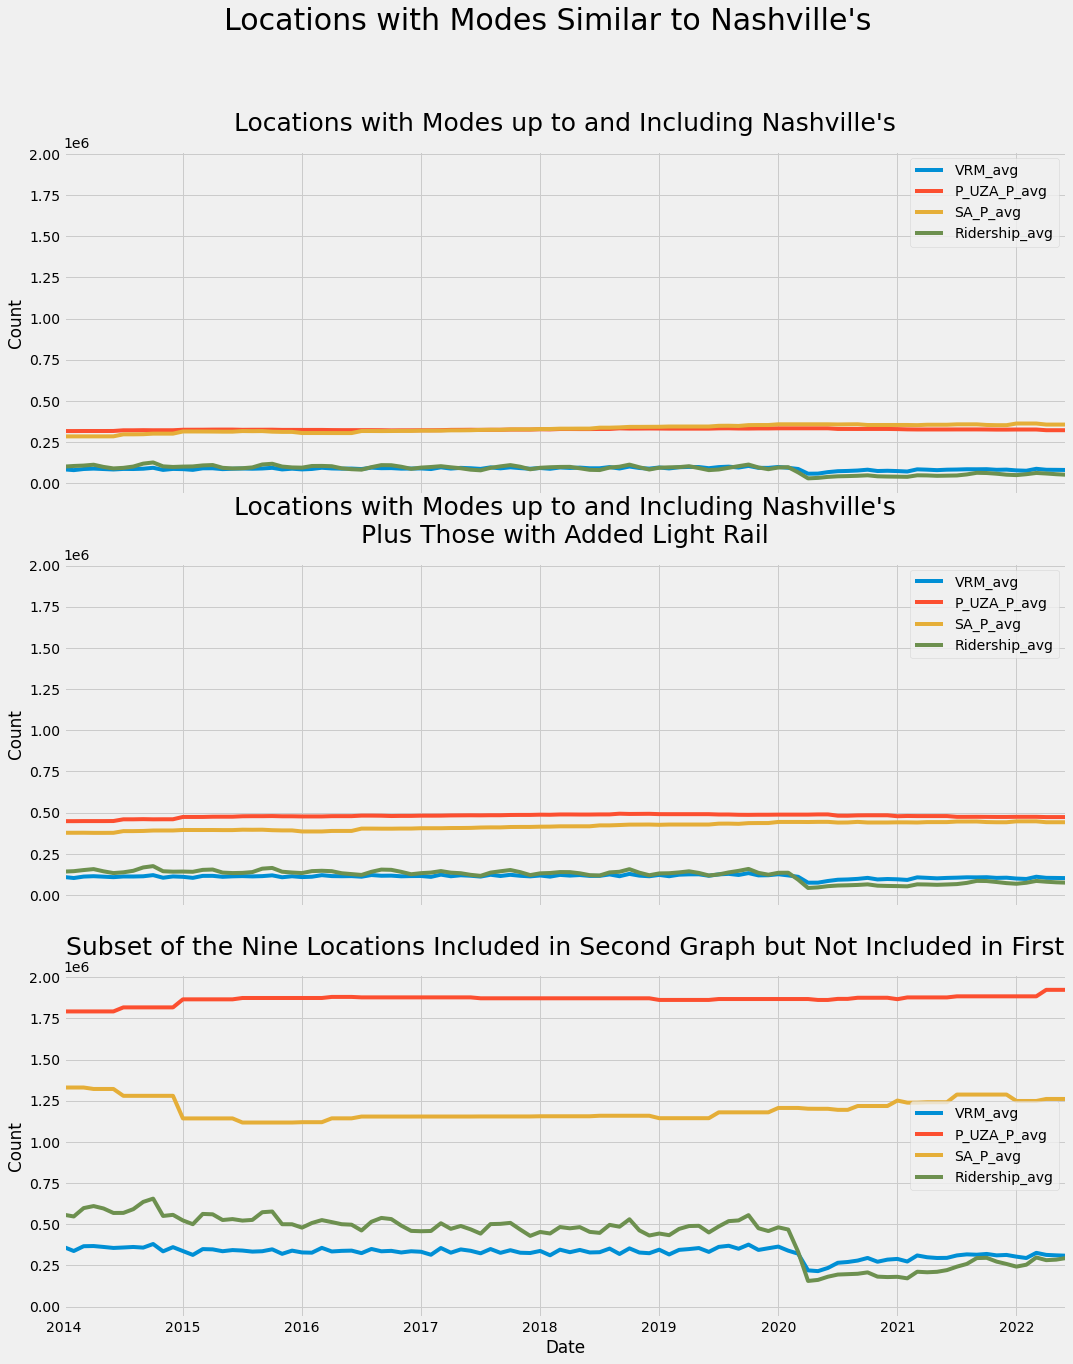

In [59]:
fig, ax =plt.subplots(3,1,figsize=(16,20), sharex=True, sharey=True)
fig.suptitle("Locations with Modes Similar to Nashville's", fontsize=30)
#plt.subplots_adjust(hspace=1)

modes_subset[['VRM_avg',
            'P_UZA_P_avg',
            'SA_P_avg',
            'Ridership_avg']].plot(kind='line',legend=True, ax=ax[0])
ax[0].set_title("Locations with Modes up to and Including Nashville's", fontsize=25, pad=20)
ax[0].set_ylabel("Count")

modes_subset_plus_LR[['VRM_avg',
            'P_UZA_P_avg',
            'SA_P_avg',
            'Ridership_avg']].plot(kind='line',legend=True, ax=ax[1])
ax[1].set_title("Locations with Modes up to and Including Nashville's\nPlus Those with Added Light Rail", fontsize=25, pad=20)
ax[1].set_ylabel("Count")


modes_subset_LR[['VRM_avg',
            'P_UZA_P_avg',
            'SA_P_avg',
            'Ridership_avg']].plot(kind='line',legend=True, ax=ax[2])
ax[2].set_title("Subset of the Nine Locations Included in Second Graph but Not Included in First", fontsize=25, pad=20)
ax[2].set_ylabel("Count")


plt.show()

Through these visuals, I can see that the nine locations with modes up to an including Nashville's but which include light rail have a substantially greater average population size for both the primary UZA and the service area.  They also have an appreciable increase in the average number of vehicle revenue miles and ridership.

## 3.8 Encode and Aggregating the Data for Modeling
<a id='3.8_Encoding_and_Aggregating_the_Data_for_Modeling'></a>


In [60]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 129752 entries, 2014-01-01 to 2022-06-01
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   5 DIgit NTD ID           129752 non-null  int64  
 1   Agency                   129752 non-null  object 
 2   Organization Type        129752 non-null  object 
 3   Mode                     129752 non-null  object 
 4   Type of Service          129752 non-null  object 
 5   Rail (Y/N)               129752 non-null  bool   
 6   Primary UZA Code         129752 non-null  float64
 7   Primary UZA Name         129752 non-null  object 
 8   Primary UZA Sq Miles     129752 non-null  float64
 9   Primary UZA Population   129752 non-null  float64
 10  Service Area Sq Miles    129752 non-null  float64
 11  Service Area Population  129752 non-null  float64
 12  Year                     129752 non-null  int64  
 13  Month                    129752 non-null  i

### 3.8.1 Encoding the Categorical Features
<a id= '3.8_Encoding_the_Categorical_Features'></a>
Time to encode the categorical variables: 'Organization Type', 'Mode', and 'Type of Service'.  Since the names for the types of organizations are so long, I will map them to letters of the alphabet based on the number of times they appear in the National dataframe.

In [61]:
National_data['Organization Type'].value_counts()

Independent Public Agency or Authority of Transit Service                68469
City, County or Local Government Unit or Department of Transportation    46395
MPO, COG or Other Planning Agency                                         2790
State Government Unit or Department of Transportation                     2304
Other Publicly-Owned or Privately Chartered Corporation                   1918
Subsidiary Unit of a Transit Agency, Reporting Separately                 1866
Private-Non-Profit Corporation                                            1721
Private-For-Profit Corporation                                            1573
University                                                                1278
Private Provider Reporting on Behalf of a Public Entity                   1180
Other                                                                      132
Consolidated Reporter                                                      126
Name: Organization Type, dtype: int64

In [62]:
#Renaming the Organization Types so the dummied column names won't be so cumbersome

National_data['Organization Type'] = National_data['Organization Type'].map({
    'Independent Public Agency or Authority of Transit Service' : 'A',
    'Subsidiary Unit of a Transit Agency, Reporting Separately' : 'F',
    'City, County or Local Government Unit or Department of Transportation': 'B',
    'University': 'I',
    'Consolidated Reporter': 'L',
    'Other': 'K',
    'Private-For-Profit Corporation': 'H',
    'Private Provider Reporting on Behalf of a Public Entity': 'J',
    'MPO, COG or Other Planning Agency': 'C',
    'State Government Unit or Department of Transportation': 'D',
    'Private-Non-Profit Corporation': 'G',
    'Other Publicly-Owned or Privately Chartered Corporation': 'E'})


In [63]:
#Nashville_data['Organization Type'].unique()

In [64]:
#Nashville_data['Organization Type'] = Nashville_data['Organization Type'].map({
#    'Independent Public Agency or Authority of Transit Service' : 'A',
#    'Private Provider Reporting on Behalf of a Public Entity': 'J',})


In [65]:
#National_data['Organization Type'].value_counts()

In [66]:
#Nashville_data['Organization Type'].value_counts()

In [67]:
National_data = pd.get_dummies(National_data, columns=['Mode','Organization Type','Type of Service'], prefix=['M','OT','ToS'])
#Nashville_data = pd.get_dummies(Nashville_location, columns=['Mode','Organization Type','Type of Service'], prefix=['M','OT','ToS'])


In [68]:
National_data.shape

(129752, 49)

In [69]:
#Nashville_data.shape

In [70]:
# Change dtype of 'Rail (Y/N)' to uint8
#National_location['Rail (Y/N)'] = National_location['Rail (Y/N)'].astype(np.uint8)
#Nashville_location['Rail (Y/N)'] = Nashville_location['Rail (Y/N)'].astype(np.uint8)


In [71]:
#National_location.info()

In [72]:
#Nashville_location.info()

In [73]:
#National_data['Mode'].unique()

In [74]:
#National_data['Type of Service'].unique()

In [75]:
#National_data['Organization Type'].unique()

In [76]:
National_data.columns

Index(['5 DIgit NTD ID', 'Agency', 'Rail (Y/N)', 'Primary UZA Code',
       'Primary UZA Name', 'Primary UZA Sq Miles', 'Primary UZA Population',
       'Service Area Sq Miles', 'Service Area Population', 'Year', 'Month',
       'Vehicles', 'Vehicle Revenue Miles', 'Vehicle Revenue Hours',
       'Ridership', 'Total Events', 'Total Fatalities', 'Total Injuries',
       'all_Modes', 'M_CB', 'M_CC', 'M_CR', 'M_DR', 'M_HR', 'M_LR', 'M_MB',
       'M_MG', 'M_RB', 'M_SR', 'M_TB', 'M_TR', 'M_VP', 'M_YR', 'OT_A', 'OT_B',
       'OT_C', 'OT_D', 'OT_E', 'OT_F', 'OT_G', 'OT_H', 'OT_I', 'OT_J', 'OT_K',
       'OT_L', 'ToS_DO', 'ToS_PT', 'ToS_TN', 'ToS_TX'],
      dtype='object')

### 3.8.2 Creating '...OTHER' Columns for Mode and Organization Type
<a id='3.8.2_Creating_OTHER_Columns_for_Mode_and_Organization_Type'></a>
I will reduce the number of mode columns in the following manner:  I will leave separate columns for all modes which Nashville currently has and also for light rail, which Nashville might consider adding.  All other modes will be combined into the M_OTHER column.  

I will reduce the number of organization type columns by one by combining the OT_K and OT_L columns into an OT_OTHER column since the number of occurrences for these two organization types in the database was very low.

In [77]:

National_data['M_OTHER'] = (National_data['M_CC'] + National_data['M_HR'] +
                            National_data['M_MG'] + National_data['M_RB'] + 
                            National_data['M_SR'] + National_data['M_TB'] + 
                            National_data['M_TR'] + National_data['M_YR'])

National_data['OT_OTHER'] = (National_data['OT_K'] + National_data['OT_L'])

### 3.8.3 Aggregating to a New Dataframe for Modeling
<a id='3.8.3_Aggregating_to_a_New_Dataframe_for_Modeling'></a>
Choosing the features: 

'Primary UZA Code' and 'Primary UZA Population' are both ordinal representations of the ranking of population size.  However, 'Primary UZA Code' has the one value (602) which is out of place.  So, 'Primary UZA Population' will be used.

The columns 'Vehicles' and 'Vehicle Revenue Hours' will not be used because they are too closely related to 'Vehicle Revenue Miles' which will be used to calculate the target.


|  |  |
|:---------|:-------------|
|Time|Time|
|Dimensions||
|Features|Mode (encoded and reduced)|
||Type of Service (ecoded)|
||Organization Type (encoded and reduced)|
||Primary UZA Sq Miles|
||Primary UZA Population|
||Service Area Sq Miles|
||Service Area Population|
||Ridership|
|Target|Safety Ratio|

In [78]:
modeling_df = National_data.groupby('Date').agg(
    Fatalities_sum=('Total Fatalities', 'sum'),
    Injuries_sum=('Total Injuries', 'sum'),
    Events_sum=('Total Events', 'sum'),
    VRM_sum=('Vehicle Revenue Miles','sum'),
    P_UZA_SM_sum = ('Primary UZA Sq Miles', 'sum'),
    P_UZA_P_sum = ('Primary UZA Population', 'sum'),
    SA_SM_sum = ('Service Area Sq Miles', 'sum'),
    SA_P_sum = ('Service Area Population', 'sum'),
    Ridership_sum = ('Ridership','sum'),
    M_CB_Count = ('M_CB', 'sum'),
    M_CR_Count = ('M_CR', 'sum'),
    M_DR_Count = ('M_DR', 'sum'),
    M_MB_Count = ('M_MB', 'sum'),
    M_VP_Count = ('M_VP', 'sum'),
    M_LR_Count = ('M_LR', 'sum'),
    M_OTHER_Count = ('M_OTHER', 'sum'),
    OT_A_Count = ('OT_A', 'sum'),
    OT_B_Count = ('OT_B', 'sum'),
    OT_C_Count = ('OT_C', 'sum'),
    OT_D_Count = ('OT_D', 'sum'),
    OT_E_Count = ('OT_E', 'sum'),
    OT_F_Count = ('OT_F', 'sum'),
    OT_G_Count = ('OT_G', 'sum'),
    OT_H_Count = ('OT_H', 'sum'),
    OT_I_Count = ('OT_I', 'sum'),
    OT_J_Count = ('OT_J', 'sum'),
    OT_OTHER_Count = ('OT_OTHER', 'sum'),
    ToS_DO_Count = ('ToS_DO', 'sum'),
    ToS_PT_Count = ('ToS_PT', 'sum'),
    ToS_TN_Count = ('ToS_TN', 'sum'),
    ToS_TX_Count = ('ToS_TX', 'sum')
)


In [79]:
modeling_df.head()

Fatalities_sum  Injuries_sum  Events_sum    VRM_sum  P_UZA_SM_sum  \
Date                                                                            
2014-01-01              20           797         531  328452031      835383.0   
2014-02-01              18           853         528  302314486      834860.0   
2014-03-01              23           903         536  332714067      834795.0   
2014-04-01              16           777         505  337326111      834795.0   
2014-05-01              18           998         558  335112466      835384.0   

             P_UZA_P_sum  SA_SM_sum      SA_P_sum  Ridership_sum  M_CB_Count  \
Date                                                                           
2014-01-01  3.169535e+09   744560.0  1.320043e+09      808103664         100   
2014-02-01  3.168173e+09   744025.0  1.318963e+09      788740957         100   
2014-03-01  3.168056e+09   743401.0  1.318734e+09      888517154         100   
2014-04-01  3.168056e+09   739897.0  1.318133e+09      895729521         100   
2014-05-01  3.169138e+09   740804.0  1.318288e+09      898413957         101   

            ...  OT_F_Count  OT_G_Count  OT_H_Count  OT_I_Count  OT_J_Count  \
Date        ...                                                               
2014-01-01  ...          28          16          21           9          14   
2014-02-01  ...          28          16          21           9          14   
2014-03-01  ...          28          16          21           9          14   
2014-04-01  ...          28          16          21           9          14   
2014-05-01  ...          28          16          21           9          14   

            OT_OTHER_Count  ToS_DO_Count  ToS_PT_Count  ToS_TN_Count  \
Date                                                                   
2014-01-01              14         690.0         502.0             0   
2014-02-01              14         689.0         502.0             0   
2014-03-01              14         689.0         502.0             0   
2014-04-01              14         689.0         502.0             0   
2014-05-01              14         689.0         504.0             0   

            ToS_TX_Count  
Date                      
2014-01-01            73  
2014-02-01            73  
2014-03-01            72  
2014-04-01            72  
2014-05-01            72  

[5 rows x 31 columns]

In [80]:
modeling_df.shape

(102, 31)

## 3.9 Creating the Target
<a id='3.9_Creating_the_Target'></a>

### 3.9.1 Creating the 'Safety Ratio' Column
<a id='3.9.1_Creating_the_Safety_Ratio_Column'></a>
Here I will define the target (dependent variable, y) from the aggregated data using this formula:

SAFETY RATIO = ((FATALITIES + INJURIES + EVENTS)/ VEHICLE REVENUE MILES) * 100000

In [81]:
National_Safety = (modeling_df['Fatalities_sum'] + modeling_df['Injuries_sum'] + modeling_df['Events_sum'])
#Nashville_Safety = (Nashville_data['Total Fatalities'] + Nashville_data['Total Injuries'] + Nashville_data['Total Events'])

modeling_df['Safety Ratio'] = (National_Safety/modeling_df['VRM_sum'])*100000
#Nashville_data['Safety Ratio'] = (Nashville_Safety/Nashville_data['Vehicle Revenue Miles'])*100000


In [82]:
modeling_df['Safety Ratio'].isna().sum()

0

In [83]:
#Nashville_data['Safety Ratio'].isna().sum()


In [84]:
#In rows where there were no fatalities, injuries, or events, 
#I end up with Nans because I have divided by zero.  
#I will replace the Nans with zeros since that is the logical value.

#modeling_df['Safety Ratio'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
#modeling_df['Safety Ratio'].isna().sum()


In [85]:
#modeling_df['Safety Ratio'].isna().sum()

In [86]:
#modeling_df.shape

### 3.9.2 Dropping the Columns Used to Calculate 'Safety Ratio'
<a id='3.9.2_Dropping_the_Columns_Used_to_Calculate_Safety_Ratio'></a>
I will now drop the 'VRM_sum', 'Fatalities_sum', 'Injuries_sum', and 'Events_sum' columns since they are accounted for in the new 'Safety Ratio' column.

In [87]:
modeling_df = modeling_df.drop(['VRM_sum', 'Fatalities_sum','Injuries_sum','Events_sum'], axis=1)
#modeling_df = modeling_df.drop(['Vehicle Revenue Miles', 'Total Fatalities','Total Injuries','Total Events'], axis=1)


In [88]:
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102 entries, 2014-01-01 to 2022-06-01
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   P_UZA_SM_sum    102 non-null    float64
 1   P_UZA_P_sum     102 non-null    float64
 2   SA_SM_sum       102 non-null    float64
 3   SA_P_sum        102 non-null    float64
 4   Ridership_sum   102 non-null    int64  
 5   M_CB_Count      102 non-null    uint8  
 6   M_CR_Count      102 non-null    uint8  
 7   M_DR_Count      102 non-null    float64
 8   M_MB_Count      102 non-null    float64
 9   M_VP_Count      102 non-null    uint8  
 10  M_LR_Count      102 non-null    uint8  
 11  M_OTHER_Count   102 non-null    uint8  
 12  OT_A_Count      102 non-null    float64
 13  OT_B_Count      102 non-null    float64
 14  OT_C_Count      102 non-null    uint8  
 15  OT_D_Count      102 non-null    uint8  
 16  OT_E_Count      102 non-null    uint8  
 17  OT_F_Count      

## 3.10 Exploring the Data
<a id='3.10_Exploring_the_Data)'></a>
I will take a new look at the statistics and relationships now that the target and features are now clearly defined.

In [89]:
modeling_df.describe()

P_UZA_SM_sum   P_UZA_P_sum      SA_SM_sum      SA_P_sum  \
count     102.000000  1.020000e+02     102.000000  1.020000e+02   
mean   847886.107843  3.174275e+09  840027.509804  1.274264e+09   
std     11781.626316  3.846492e+07   34951.872161  3.711102e+07   
min    822350.000000  3.079335e+09  739897.000000  1.214880e+09   
25%    837695.500000  3.160831e+09  819916.000000  1.246144e+09   
50%    851810.500000  3.187248e+09  844527.500000  1.265943e+09   
75%    856467.000000  3.199410e+09  866778.250000  1.311272e+09   
max    864469.000000  3.217584e+09  889285.000000  1.343547e+09   

       Ridership_sum  M_CB_Count  M_CR_Count  M_DR_Count  M_MB_Count  \
count   1.020000e+02  102.000000  102.000000  102.000000  102.000000   
mean    6.966535e+08   93.284314   26.215686  517.656863  466.823529   
std     2.143982e+08    7.281303    1.958113    5.669957    5.569385   
min     1.575090e+08   83.000000   23.000000  507.000000  454.000000   
25%     4.917120e+08   87.000000   24.000000  513.000000  463.000000   
50%     7.949211e+08   90.000000   26.000000  520.000000  467.000000   
75%     8.402082e+08  101.750000   28.000000  522.000000  471.000000   
max     9.614771e+08  105.000000   30.000000  526.000000  477.000000   

       M_VP_Count  ...  OT_G_Count  OT_H_Count  OT_I_Count  OT_J_Count  \
count  102.000000  ...  102.000000  102.000000  102.000000  102.000000   
mean    81.058824  ...   16.872549   15.421569   12.529412   11.568627   
std      5.610851  ...    2.712901    2.712042    0.982076    3.536261   
min     72.000000  ...   14.000000   13.000000    9.000000    6.000000   
25%     75.000000  ...   15.000000   13.000000   12.000000   10.000000   
50%     82.000000  ...   16.000000   15.000000   13.000000   10.000000   
75%     86.000000  ...   18.000000   17.000000   13.000000   14.000000   
max     88.000000  ...   23.000000   21.000000   13.000000   17.000000   

       OT_OTHER_Count  ToS_DO_Count  ToS_PT_Count  ToS_TN_Count  ToS_TX_Count  \
count      102.000000    102.000000    102.000000    102.000000    102.000000   
mean         2.529412    663.970588    540.735294      2.009804     65.362745   
std          4.658020     20.913048     18.962144      2.615624      5.083051   
min          0.000000    629.000000    502.000000      0.000000     54.000000   
25%          0.000000    647.250000    527.000000      0.000000     62.250000   
50%          0.000000    658.500000    543.000000      0.000000     67.000000   
75%          3.000000    685.000000    558.000000      4.750000     69.000000   
max         14.000000    692.000000    564.000000      7.000000     73.000000   

       Safety Ratio  
count    102.000000  
mean       0.473897  
std        0.042941  
min        0.334532  
25%        0.452397  
50%        0.477122  
75%        0.507026  
max        0.573456  

[8 rows x 28 columns]

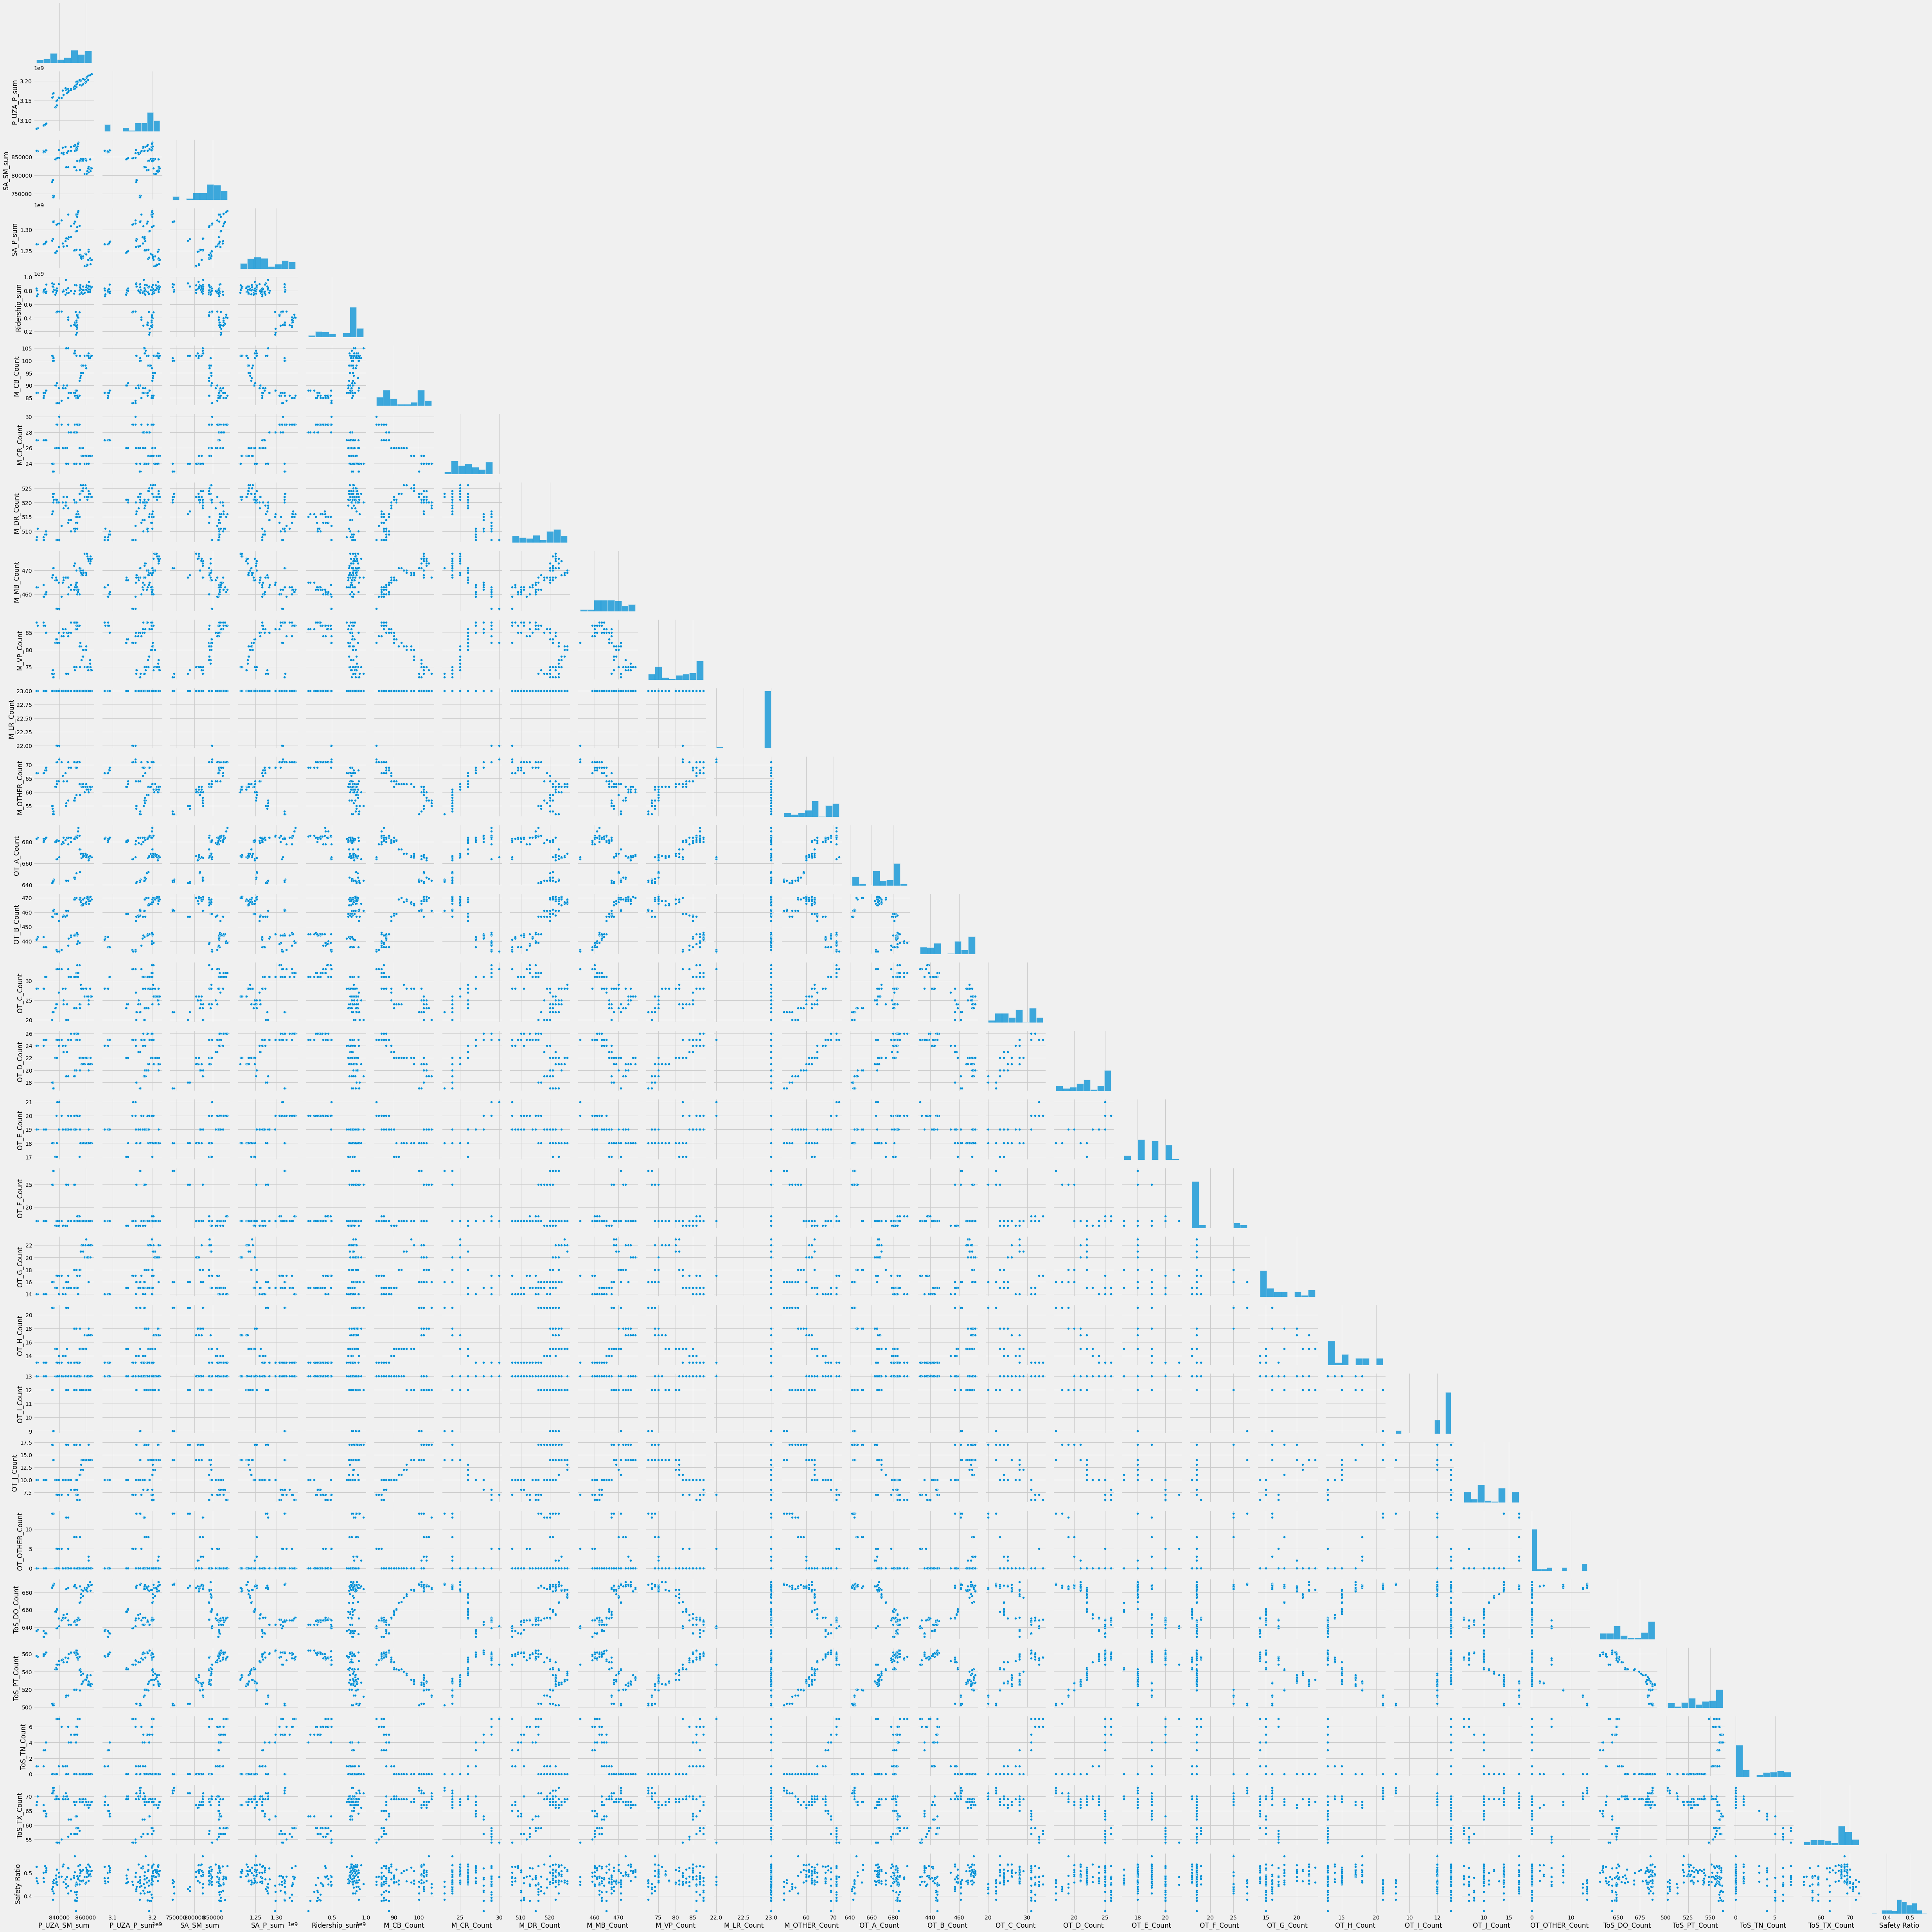

In [90]:
sns.pairplot(modeling_df, corner=True)

<AxesSubplot:>

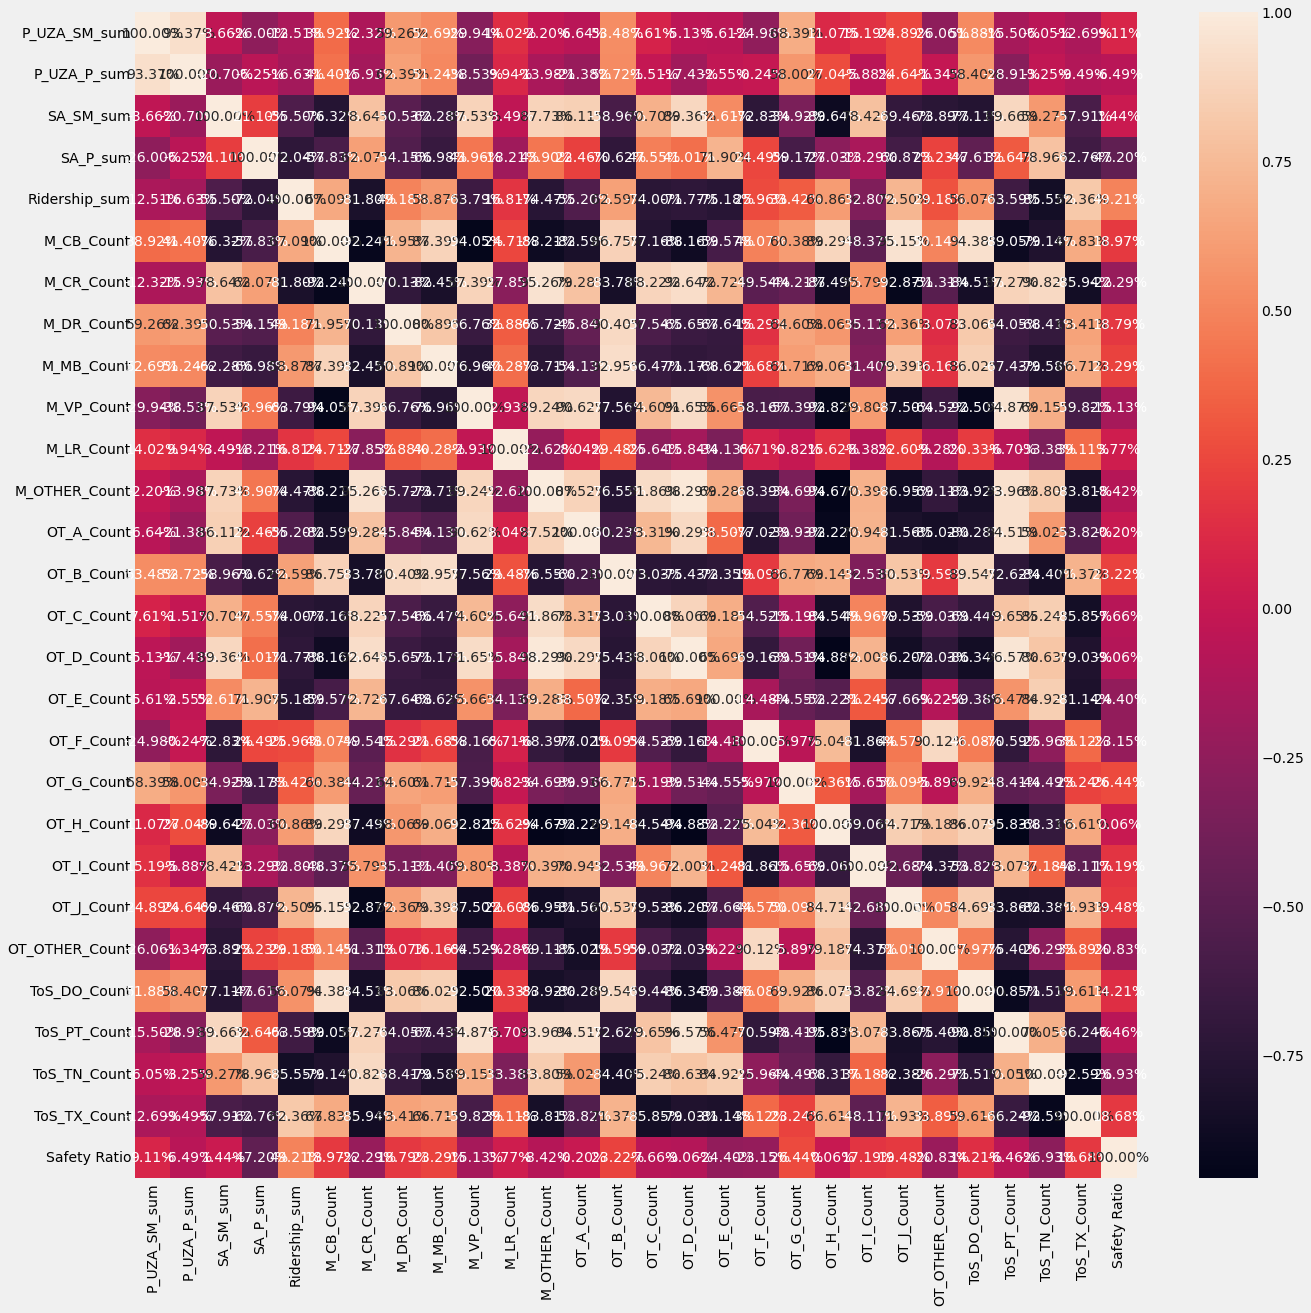

In [91]:
plt.subplots(figsize=(20,20))
sns.heatmap(modeling_df.corr(), annot=True, fmt='.2%')

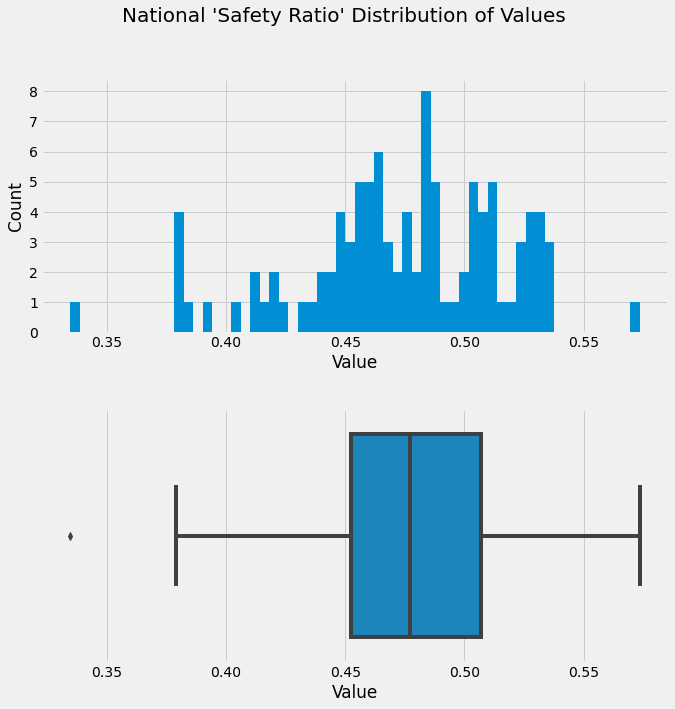

In [92]:
fig, ax =plt.subplots(2,1,figsize=(10,10), sharex=False)
fig.suptitle("National 'Safety Ratio' Distribution of Values", fontsize=20)


modeling_df.hist('Safety Ratio', bins=60, ax=ax[0])
ax[0].set_title("", fontsize=10, pad=20)
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Count")

sns.boxplot(data=modeling_df, x='Safety Ratio', ax=ax[1])
ax[1].set_title('', fontsize=12, pad=20)
ax[1].set_xlabel("Value");


## 3.8 Model Trials: Regression
<a id= '3.8_Model_Trials_Regression'></a>
I will try three different regression models to see their usefulness for prediction.  The train/test split will respect time order.

In [93]:
modeling_df['Safety Ratio'].min()

0.334531842434836

### 3.11.1 Train/Test Split
<a id= '3.11.1_Train_Test_Split'></a>

In [94]:
modeling_df.reset_index(inplace=True)
modeling_df = modeling_df.drop(columns='Date')

In [95]:
#Defining X and y from National_data

X = modeling_df.drop(['Safety Ratio'], axis = 1)
y = modeling_df['Safety Ratio']

In [96]:
# Train/Test split respecting time order (shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)
X_train.index.min(), X_train.index.max()

(0, 80)

In [97]:
X_test.index.min(), X_test.index.max()

(81, 101)

### 3.11.2 Linear Regression
<a id= '3.11.2_Linear_Regression'></a>


In [98]:
Model_lr = LinearRegression()

In [99]:
Model_lr.fit(X_train, y_train)

LinearRegression()

In [100]:
y_pred_lr = Model_lr.predict(X_test)

In [101]:
#Evaluation

R2_score_lr = Model_lr.score(X_train, y_train)
print("R Squared score:", R2_score_lr)

MAPE_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
print("MAPE:", MAPE_lr)

MAE_lr = mean_absolute_error(y_test, y_pred_lr)
print("MAE:", MAE_lr)

MSE_lr = mean_squared_error(y_test, y_pred_lr)
print("MSE:", MSE_lr)

R Squared score: 0.6243253315460584
MAPE: 0.08566313264664469
MAE: 0.039779128032078344
MSE: 0.0024374525146698125


In [102]:
diff_lr = (y_test - y_pred_lr)

y_test_series = pd.Series(y_test, name='y_test')
y_pred_lr_series = pd.Series(y_pred_lr, name='y_pred_lr')
diff_lr_series = pd.Series(diff_lr, name='residual_lr')

y_pred_lr_series.index = y_test_series.index

data_lr=pd.concat([y_test_series, y_pred_lr_series, diff_lr_series], axis=1)



data_lr



y_test  y_pred_lr  residual_lr
81   0.380515   0.426321    -0.045806
82   0.417012   0.417027    -0.000015
83   0.392577   0.411395    -0.018819
84   0.378903   0.435644    -0.056740
85   0.447780   0.430427     0.017353
86   0.406094   0.436021    -0.029927
87   0.454975   0.443996     0.010979
88   0.449671   0.448306     0.001365
89   0.484801   0.469808     0.014994
90   0.529945   0.423108     0.106838
91   0.480805   0.430646     0.050159
92   0.474797   0.440237     0.034560
93   0.487469   0.433518     0.053951
94   0.449826   0.416415     0.033410
95   0.485510   0.412661     0.072849
96   0.444315   0.409158     0.035157
97   0.522002   0.416406     0.105596
98   0.484009   0.426393     0.057616
99   0.461858   0.496520    -0.034661
100  0.448510   0.499414    -0.050904
101  0.483559   0.487220    -0.003661

In [103]:
mode = lambda x: pd.Series.mode(x)[0]
data_agg_lr = data_lr.agg({
        "y_test": ["min", "max", "median", "mean", mode, "std"],
        "y_pred_lr": ["min", "max", "median", "mean", mode, "std"],
        "residual_lr": ["min", "max", "median", "mean", mode, "std"],})
data_agg_lr

y_test  y_pred_lr  residual_lr
min       0.378903   0.409158    -0.056740
max       0.529945   0.499414     0.106838
median    0.454975   0.430646     0.014994
mean      0.455473   0.438602     0.016871
<lambda>  0.378903   0.409158    -0.056740
std       0.041875   0.027348     0.047544

### 3.11.3 Random Forest
<a id= '3.11.3_Random_Forest'></a>

In [104]:
Model_rf = RandomForestRegressor()

In [105]:
Model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [106]:
y_pred_rf = Model_rf.predict(X_test)

In [107]:
#Evaluation

R2_score_rf = Model_rf.score(X_train, y_train)
print("R Squared score:", R2_score_rf)

MAPE_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print("MAPE:", MAPE_rf)

MAE_rf = mean_absolute_error(y_test, y_pred_rf)
print("MAE:", MAE_rf)

MSE_rf = mean_squared_error(y_test, y_pred_rf)
print("MSE:", MSE_rf)

R Squared score: 0.90034512203968
MAPE: 0.0672531958774334
MAE: 0.031212505776154035
MSE: 0.001401680620562529


In [108]:
diff_rf = (y_test - y_pred_rf)

y_test_series = pd.Series(y_test, name='y_test')
y_pred_rf_series = pd.Series(y_pred_rf, name='y_pred_rf')
diff_rf_series = pd.Series(diff_rf, name='residual_rf')

y_pred_rf_series.index = y_test_series.index

data_rf=pd.concat([y_test_series, y_pred_rf_series, diff_rf_series], axis=1)
data_rf




y_test  y_pred_rf  residual_rf
81   0.380515   0.423574    -0.043060
82   0.417012   0.421233    -0.004221
83   0.392577   0.413383    -0.020807
84   0.378903   0.409518    -0.030615
85   0.447780   0.410596     0.037184
86   0.406094   0.413848    -0.007754
87   0.454975   0.414521     0.040455
88   0.449671   0.414521     0.035151
89   0.484801   0.415300     0.069501
90   0.529945   0.444704     0.085242
91   0.480805   0.443880     0.036925
92   0.474797   0.443880     0.030917
93   0.487469   0.448141     0.039328
94   0.449826   0.447841     0.001985
95   0.485510   0.447841     0.037669
96   0.444315   0.464531    -0.020216
97   0.522002   0.466239     0.055762
98   0.484009   0.466279     0.017730
99   0.461858   0.467393    -0.005535
100  0.448510   0.467393    -0.018883
101  0.483559   0.467035     0.016524

In [109]:
mode = lambda x: pd.Series.mode(x)[0]
data_agg_rf = data_rf.agg({
        "y_test": ["min", "max", "median", "mean", mode, "std"],
        "y_pred_rf": ["min", "max", "median", "mean", mode, "std"],
        "residual_rf": ["min", "max", "median", "mean", mode, "std"],})
data_agg_rf

y_test  y_pred_rf  residual_rf
min       0.378903   0.409518    -0.043060
max       0.529945   0.467393     0.085242
median    0.454975   0.443880     0.017730
mean      0.455473   0.438650     0.016823
<lambda>  0.378903   0.414521    -0.043060
std       0.041875   0.022508     0.034272

### 3.11.4 KNN
<a id= '3.11.4_KNN'></a>

In [110]:
Model_knn = KNeighborsRegressor()

In [111]:
Model_knn.fit(X_train, y_train)

KNeighborsRegressor()

In [112]:
y_pred_knn = Model_knn.predict(X_test)

In [113]:
#Evaluation

R2_score_knn = Model_knn.score(X_train, y_train)
print("R Squared score:", R2_score_knn)

MAPE_knn = mean_absolute_percentage_error(y_test, y_pred_knn)
print("MAPE:", MAPE_knn)

MAE_knn = mean_absolute_error(y_test, y_pred_knn)
#MAE_knn_values = mean_absolute_error(y_test, y_pred_knn, multioutput='raw_values')
print("MAE:", MAE_knn)

MSE_knn = mean_squared_error(y_test, y_pred_knn)
print("MSE:", MSE_knn)

R Squared score: 0.5456434963800347
MAPE: 0.07922033025772998
MAE: 0.03723871152083443
MSE: 0.0020177794354046498


In [114]:
diff_knn = (y_test - y_pred_knn)

y_test_series = pd.Series(y_test, name='y_test')
y_pred_knn_series = pd.Series(y_pred_knn, name='y_pred_knn')
diff_knn_series = pd.Series(diff_knn, name='residual_knn')

y_pred_knn_series.index = y_test_series.index

data_knn=pd.concat([y_test_series, y_pred_knn_series, diff_knn_series], axis=1)
data_knn




y_test  y_pred_knn  residual_knn
81   0.380515    0.416281     -0.035766
82   0.417012    0.416281      0.000732
83   0.392577    0.416281     -0.023704
84   0.378903    0.416281     -0.037377
85   0.447780    0.416281      0.031499
86   0.406094    0.416281     -0.010186
87   0.454975    0.429280      0.025695
88   0.449671    0.429280      0.020392
89   0.484801    0.429280      0.055521
90   0.529945    0.429280      0.100666
91   0.480805    0.429280      0.051525
92   0.474797    0.429280      0.045517
93   0.487469    0.429280      0.058190
94   0.449826    0.429280      0.020546
95   0.485510    0.429280      0.056230
96   0.444315    0.429280      0.015035
97   0.522002    0.429280      0.092722
98   0.484009    0.450928      0.033081
99   0.461858    0.429280      0.032579
100  0.448510    0.450928     -0.002418
101  0.483559    0.450928      0.032631

In [115]:
mode = lambda x: pd.Series.mode(x)[0]
data_agg_knn = data_knn.agg({
        "y_test": ["min", "max", "median", "mean", mode, "std"],
        "y_pred_knn": ["min", "max", "median", "mean", mode, "std"],
        "residual_knn": ["min", "max", "median", "mean", mode, "std"],})
data_agg_knn

y_test  y_pred_knn  residual_knn
min       0.378903    0.416281     -0.037377
max       0.529945    0.450928      0.100666
median    0.454975    0.429280      0.031499
mean      0.455473    0.428658      0.026815
<lambda>  0.378903    0.429280     -0.037377
std       0.041875    0.010981      0.036928

### 3.11.5 Comparing the Models' Performance
<a id='3.11.5_Comparing_the_Models_Performance'></a>


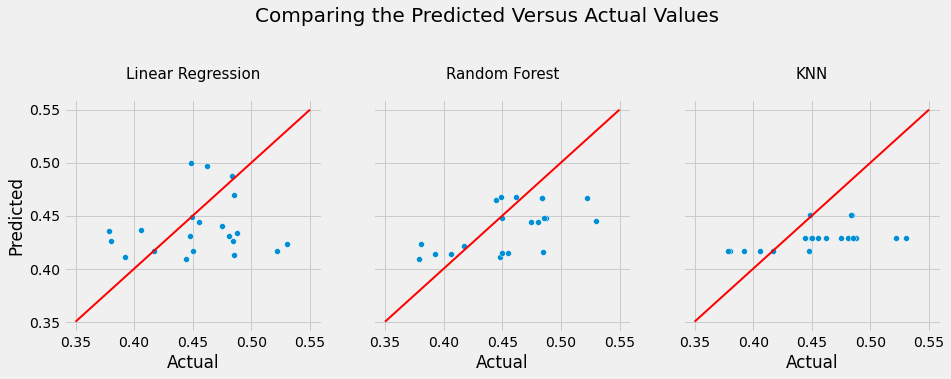

In [116]:
#Comparing the Predicted Versus Actual Values

fig, ax =plt.subplots(1,3,figsize=(14,4), sharey=True, sharex=True)
fig.suptitle("Comparing the Predicted Versus Actual Values", fontsize=20, y=1.2)


sns.scatterplot(x=y_test, y=y_pred_lr, ax=ax[0])
ax[0].set_title("Linear Regression", fontsize=15, pad=20)
ax[0].set_xlabel("Actual")
ax[0].set_ylabel("Predicted")
#ax[0].plot([x for x in range (0,2)],[x for x in range (0,2)], color='red')
ax[0].plot([0.35, 0.55], [0.35, 0.55], linewidth=2, color='red')

sns.scatterplot(x=y_test, y=y_pred_rf, ax=ax[1])
ax[1].set_title("Random Forest", fontsize=15, pad=20)
ax[1].set_xlabel("Actual")
ax[1].set_ylabel("Predicted")
#ax[1].plot([x for x in range (0,2)],[x for x in range (0,2)], color='red')
ax[1].plot([0.35, 0.55], [0.35, 0.55], linewidth=2, color='red')

sns.scatterplot(x=y_test, y=y_pred_knn, ax=ax[2])
ax[2].set_title("KNN", fontsize=15, pad=20)
ax[2].set_xlabel("Actual")
ax[2].set_ylabel("Predicted")
#ax[2].plot([x for x in range (0,2)],[x for x in range (0,2)], color='red')
ax[2].plot([0.35, 0.55], [0.35, 0.55], linewidth=2, color='red');



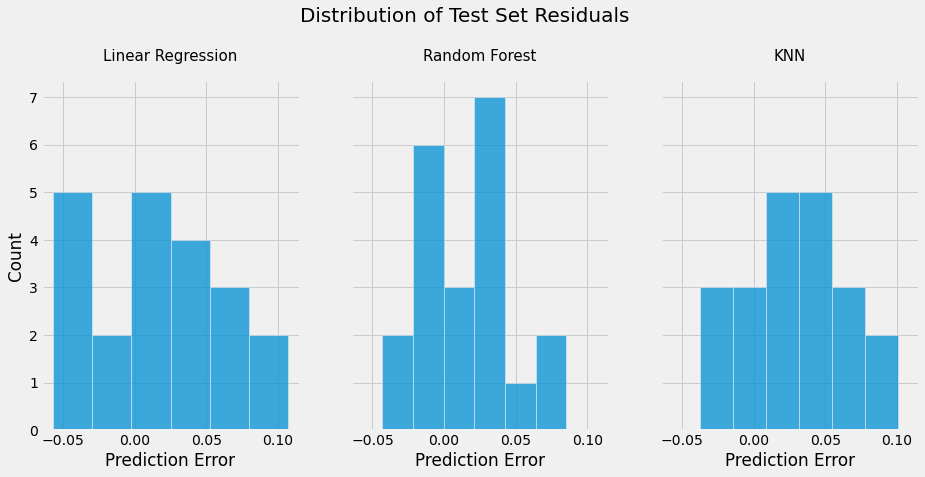

In [117]:
#Comparing the Residuals

fig, ax =plt.subplots(1,3,figsize=(14,6), sharey=True, sharex=True)
fig.suptitle("Distribution of Test Set Residuals", fontsize=20, y=1.05)


sns.histplot(diff_lr, ax=ax[0])
ax[0].set_title("Linear Regression", fontsize=15, pad=20)
ax[0].set_xlabel("Prediction Error")
ax[0].set_ylabel("Count")

sns.histplot(diff_rf, ax=ax[1])
ax[1].set_title("Random Forest", fontsize=15, pad=20)
ax[1].set_xlabel("Prediction Error")
ax[1].set_ylabel("Count")

sns.histplot(diff_knn, ax=ax[2])
ax[2].set_title("KNN", fontsize=15, pad=20)
ax[2].set_xlabel("Prediction Error")
ax[2].set_ylabel("Count");


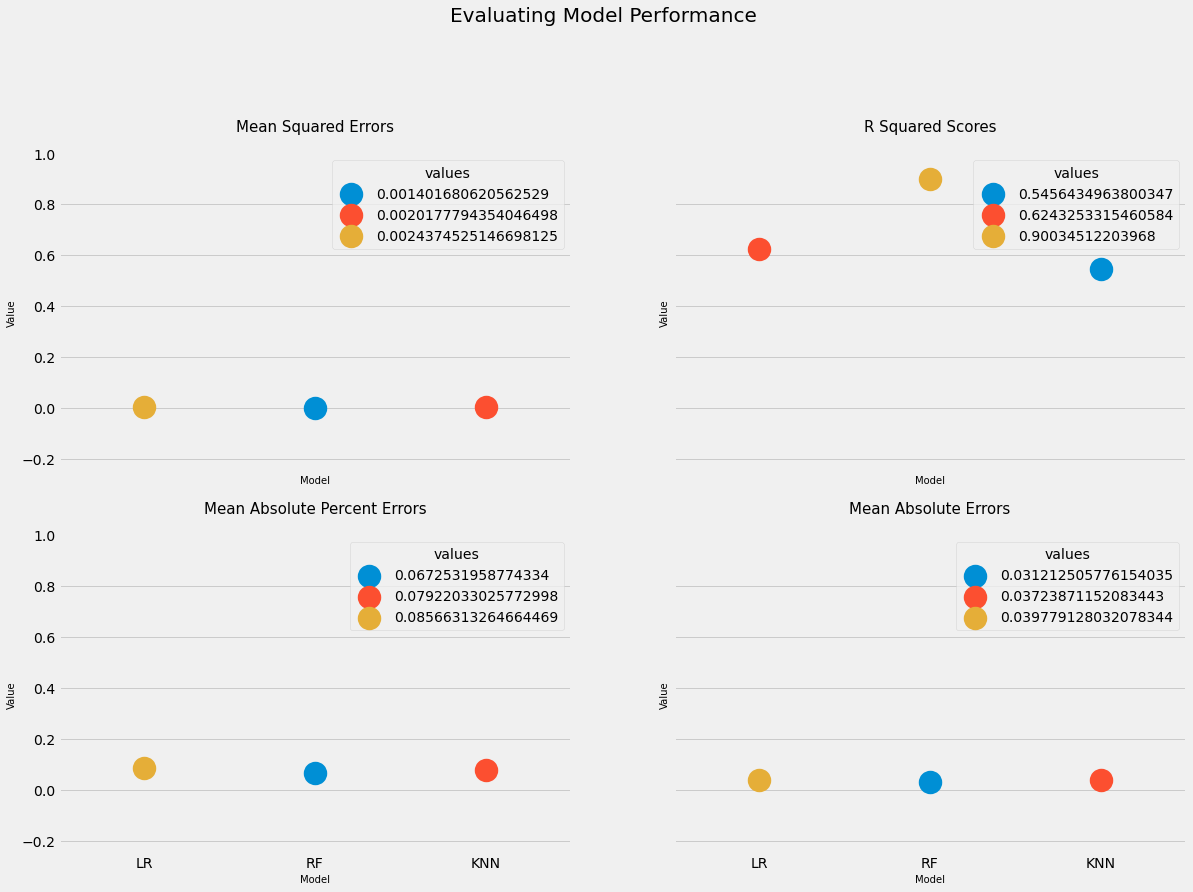

In [118]:
#Comparing the Mean Squared Error

MSEs = pd.Series([MSE_lr, MSE_rf, MSE_knn], name='values')
R2s = pd.Series([R2_score_lr, R2_score_rf, R2_score_knn], name='values')
MAPEs = pd.Series([MAPE_lr, MAPE_rf, MAPE_knn], name='values')
MAEs = pd.Series([MAE_lr, MAE_rf, MAE_knn], name='values')
labels = pd.Series(['LR','RF','KNN'], name='labels')


fig, ax =plt.subplots(2,2,figsize=(18,12), sharex=True, sharey=True)
fig.suptitle("Evaluating Model Performance", fontsize=20, y=1.05)


sns.pointplot(data=pd.concat([MSEs, labels], axis=1), 
              x='labels', y='values', 
              join=False, legend=True, 
              ax=ax[0,0], hue='values')
ax[0,0].set_title("Mean Squared Errors", fontsize=15, y=1.05)
ax[0,0].set_xlabel("Model", fontsize=10)
ax[0,0].set_ylabel("Value", fontsize=10, x=1.05)
ax[0,0].set(ylim=(-0.25, 1))

sns.pointplot(data=pd.concat([R2s, labels], axis=1), 
              x='labels', y='values', 
              join=False, legend=True, 
              ax=ax[0,1], hue='values')
ax[0,1].set_title("R Squared Scores", fontsize=15, y=1.05)
ax[0,1].set_xlabel("Model", fontsize=10)
ax[0,1].set_ylabel("Value", fontsize=10, x=1.05)
ax[0,0].set(ylim=(-0.25, 1))

sns.pointplot(data=pd.concat([MAPEs, labels], axis=1), 
              x='labels', y='values', 
              join=False, legend='brief', 
              ax=ax[1,0], hue='values')
ax[1,0].set_title("Mean Absolute Percent Errors", fontsize=15, y=1.05)
ax[1,0].set_xlabel("Model", fontsize=10)
ax[1,0].set_ylabel("Value", fontsize=10, x=1.05)
ax[0,0].set(ylim=(-0.25, 1))

sns.pointplot(data=pd.concat([MAEs, labels], axis=1), 
              x='labels', y='values', 
              join=False, legend=True, 
              ax=ax[1,1], hue='values')
ax[1,1].set_title("Mean Absolute Errors", fontsize=15, y=1.05)
ax[1,1].set_xlabel("Model", fontsize=10)
ax[1,1].set_ylabel("Value", fontsize=10, x=1.05)
ax[0,0].set(ylim=(-0.25, 1));

Random Forest appears to be the best of the three regression models.  The R Squared value is over 0.9 while the other three metrics remain quite low.

## 3.12 Save the Data
<a id='3.12_Save_the_Data'></a>

In [119]:
National_data.to_csv("National_data_post_preprocessing.csv", index=False)
Nashville_data.to_csv("Nashville_data_post_preprocessing.csv", index=False)

modeling_df.to_csv("modeling_df.csv", index=False)


## 3.13 Summary
<a id='3.13_Summary'></a>

In this notebook, I defined safety in order to establish a clear single column for the dependant variable.  I dropped columns which were redundant or unneeded and then encoded the categorical columns - reducing some by creating '...other' columns.  

I focused on regression models in this notebook but found none were useful in predicting the target values.  In the next notebook, I will pivot to time series analysis.

## Time Series Analysis (Next Notebook)